In [12]:
import os
import pickle
import neurokit2 as nk
import sensors_import_support as sis

In [13]:
# Import questionnaires and subjects data
with open('questionnaires.pkl', 'rb') as f:
    subject_data = pickle.load(f)
subject_data.describe()

,ID,Number,STAI_Total,Fatigue,Stress,Mental_Demand,Physical_Demand,Frustration,NASA_Total,PSS,NARS_S1,NARS_S2,NARS_S3,Age,Sex,Experience
count,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.000000,332.00000,332.000000,332.000000,332.000000,332.000000
mean,5.581326,7.367470,36.671687,1.771084,8.786145,2.719880,2.566265,2.478916,37.024096,13.837349,11.000000,12.14759,9.774096,32.418675,0.590361,1.304217
std,2.824581,4.416109,9.457364,0.849031,3.137251,1.430092,1.540532,1.649730,21.810071,3.435736,3.651759,3.20864,2.009086,5.884796,0.492509,0.460769
min,1.000000,1.000000,20.000000,1.000000,6.000000,1.000000,1.000000,1.000000,0.000000,9.000000,6.000000,7.00000,7.000000,26.000000,0.000000,1.000000
25%,3.000000,3.000000,30.000000,1.000000,6.000000,2.000000,1.000000,1.000000,18.000000,12.000000,9.000000,9.00000,8.000000,26.000000,0.000000,1.000000
50%,6.000000,7.000000,35.500000,2.000000,8.000000,3.000000,2.000000,2.000000,38.000000,14.000000,10.000000,13.00000,9.000000,35.000000,1.000000,1.000000
75%,8.000000,11.000000,41.000000,2.000000,10.000000,4.000000,4.000000,3.000000,53.000000,15.000000,12.000000,14.00000,11.000000,37.000000,1.000000,2.000000
max,10.000000,15.000000,67.000000,4.000000,23.000000,7.000000,7.000000,7.000000,86.000000,22.000000,19.000000,17.00000,14.000000,41.000000,1.000000,2.000000


In [14]:
# Import signals
signals, fs = sis.import_opensignals('signals_example.txt')
signals[0:10]

,time,ECG,EMG,EDA
0,0.0,-0.00665,-0.04936,4.4125
1,1.0,-0.00773,-0.11435,4.3915
2,2.0,-0.00863,-0.11975,4.3976
3,3.0,-0.00809,-0.12148,4.4014
4,4.0,-0.00683,-0.16526,4.4090
5,5.0,-0.00782,-0.14805,4.3922
6,6.0,-0.00863,-0.05718,4.3995
7,7.0,-0.00907,0.01549,4.4075
8,8.0,-0.00988,0.03701,4.3915
9,9.0,-0.00858,0.05581,4.4052


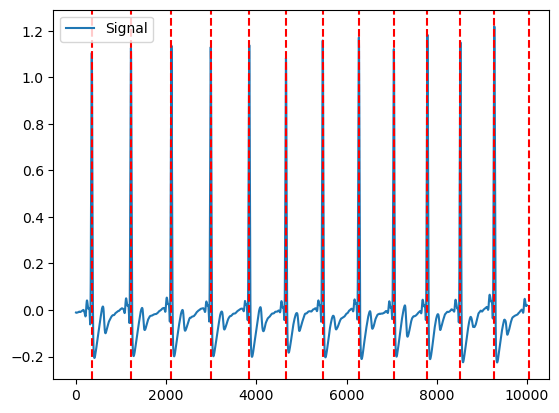

In [15]:
# Plot ecg with R peaks (only a subset, otherwise the plot becomes unreadable!)
ecg_processed, ecg_info = nk.ecg_process(signals['ECG'], sampling_rate=fs)
rpeaks = ecg_info["ECG_R_Peaks"]
cleaned_ecg = ecg_processed["ECG_Clean"]
plot = nk.events_plot(rpeaks[0:13], cleaned_ecg[0:10000])

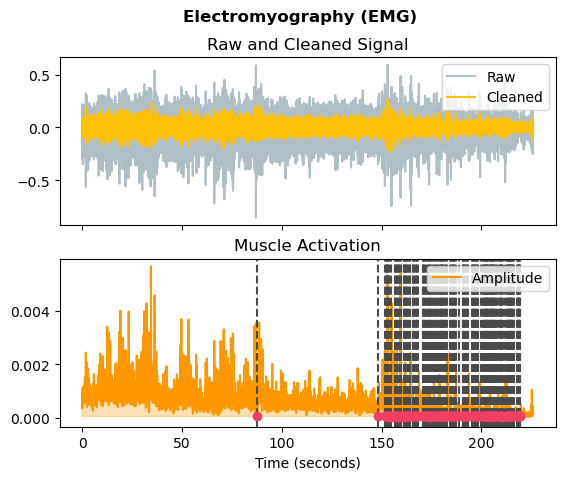

In [16]:
# Plot filtered emg
emg_processed, _ = nk.emg_process(signals['EMG'], sampling_rate=fs)
plot = nk.emg_plot(emg_processed, fs)

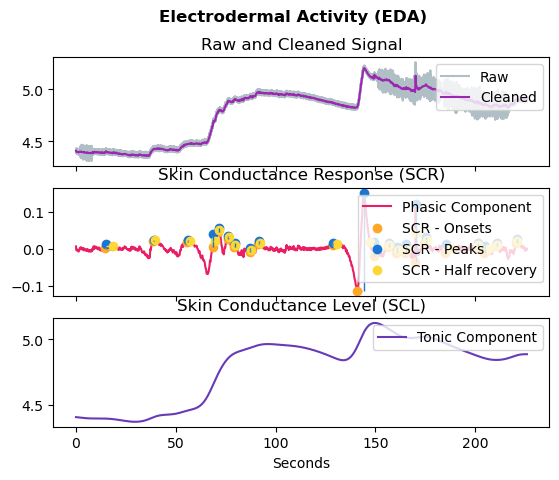

In [17]:
# Plot filtered eda
eda_processed, features = nk.eda_process(signals['EDA'], sampling_rate=fs, method="neurokit")
plot = nk.eda_plot(eda_processed, fs)

In [20]:
# Extraction of features

fs = 1000
window = 30
load_path = os.path.join(os.getcwd(), 'experiments','cobot')

In [21]:
# ECG
dataframe_ECG = sis.extract_plux_data_windowed(load_path, 0, window, 'ECG')
ecg_time_and_freq_features = sis.extract_time_and_freq_hrv_features(dataframe_ECG, fs)

100%|█████████████████████████████████████████████████████████| 983/983 [12:46<00:00,  1.28it/s]


In [ ]:
# EDA
dataframe_EDA = sis.extract_plux_data_windowed(load_path, 0, window, 'EDA')
eda_time_and_freq_features = sis.extract_eda_time_and_frequency_features(dataframe_EDA, fs, window)

  0%|                                                                   | 0/983 [00:00<?, ?it/s]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9487e+03 -5.9055e+03  3e+04  2e+02  4e+02
 1: -5.9366e+03 -6.9589e+03  1e+03  6e+00  1e+01
 2: -5.9445e+03 -6.0276e+03  8e+01  3e-01  7e-01
 3: -5.9554e+03 -5.9691e+03  1e+01  3e-03  7e-03
 4: -5.9661e+03 -5.9683e+03  2e+00  6e-04  1e-03
 5: -5.9671e+03 -5.9678e+03  7e-01  1e-04  2e-04
 6: -5.9671e+03 -5.9677e+03  6e-01  1e-04  2e-04
 7: -5.9674e+03 -5.9676e+03  2e-01  3e-05  6e-05
 8: -5.9675e+03 -5.9676e+03  8e-02  7e-06  1e-05
 9: -5.9675e+03 -5.9676e+03  7e-02  5e-06  1e-05
10: -5.9676e+03 -5.9676e+03  2e-02  1e-06  2e-06
11: -5.9676e+03 -5.9676e+03  2e-02  6e-07  1e-06
12: -5.9676e+03 -5.9676e+03  5e-03  2e-07  3e-07
13: -5.9676e+03 -5.9676e+03  5e-03  1e-07  3e-07
14: -5.9676e+03 -5.9676e+03  2e-03  2e-08  9e-08
15: -5.9676e+03 -5.9676e+03  1e-03  2e-08

  0%|                                                         | 1/983 [00:03<1:02:53,  3.84s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.7516e+04 -1.7455e+04  3e+04  2e+02  2e+02
 1: -1.7518e+04 -1.8913e+04  1e+03  8e+00  9e+00
 2: -1.7538e+04 -1.7673e+04  1e+02  6e-01  7e-01
 3: -1.7545e+04 -1.7567e+04  2e+01  2e-02  2e-02
 4: -1.7560e+04 -1.7563e+04  3e+00  3e-03  3e-03
 5: -1.7561e+04 -1.7562e+04  1e+00  2e-04  2e-04
 6: -1.7561e+04 -1.7562e+04  6e-01  2e-06  2e-06
 7: -1.7562e+04 -1.7562e+04  1e-01  4e-07  5e-07
 8: -1.7562e+04 -1.7562e+04  1e-01  2e-07  3e-07
 9: -1.7562e+04 -1.7562e+04  4e-02  7e-08  9e-08
10: -1.7562e+04 -1.7562e+04  4e-02  6e-08  8e-08
11: -1.7562e+04 -1.7562e+04  1e-02  1e-08  6e-08
12: -1.7562e+04 -1.7562e+04  1e-02  1e-08  5e-08
13: -1.7562e+04 -1.7562e+04  5e-03  9e-09  7e-08
14: -1.7562e+04 -1.7562e+04  5e-03  1e-08  6e-08
15: -1.7562e+04 -1.7562e+04  2e-03  9e-09

  0%|                                                         | 2/983 [00:07<1:02:34,  3.83s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0528e+04 -1.0360e+04  4e+04  2e+02  7e+02
 1: -1.0667e+04 -1.5451e+04  6e+03  3e+01  1e+02
 2: -1.0899e+04 -1.2130e+04  1e+03  4e+00  2e+01
 3: -1.0911e+04 -1.1070e+04  2e+02  5e-01  2e+00
 4: -1.0922e+04 -1.0950e+04  3e+01  2e-02  7e-02
 5: -1.0938e+04 -1.0943e+04  5e+00  2e-03  9e-03
 6: -1.0940e+04 -1.0941e+04  1e+00  9e-05  3e-04
 7: -1.0940e+04 -1.0941e+04  5e-01  9e-07  3e-06
 8: -1.0940e+04 -1.0940e+04  2e-01  1e-07  5e-07
 9: -1.0940e+04 -1.0940e+04  1e-01  1e-07  4e-07
10: -1.0940e+04 -1.0940e+04  4e-02  4e-08  2e-07
11: -1.0940e+04 -1.0940e+04  4e-02  4e-08  2e-07
12: -1.0940e+04 -1.0940e+04  1e-02  3e-08  2e-07
13: -1.0940e+04 -1.0940e+04  1e-02  4e-08  1e-07
14: -1.0940e+04 -1.0940e+04  4e-03  3e-08  2e-07
15: -1.

  0%|▏                                                        | 3/983 [00:11<1:01:25,  3.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5201e+02 -2.1950e+02  3e+04  2e+02  1e+03
 1: -2.4143e+02 -1.4664e+03  1e+03  7e+00  5e+01
 2: -2.4806e+02 -3.4303e+02  1e+02  4e-01  3e+00
 3: -2.5688e+02 -2.7305e+02  2e+01  4e-03  3e-02
 4: -2.6966e+02 -2.7196e+02  2e+00  6e-04  4e-03
 5: -2.7078e+02 -2.7154e+02  8e-01  1e-04  7e-04
 6: -2.7117e+02 -2.7142e+02  3e-01  2e-05  1e-04
 7: -2.7121e+02 -2.7141e+02  2e-01  1e-05  9e-05
 8: -2.7134e+02 -2.7138e+02  5e-02  2e-06  1e-05
 9: -2.7135e+02 -2.7138e+02  3e-02  1e-06  6e-06
10: -2.7137e+02 -2.7138e+02  1e-02  2e-07  2e-06
11: -2.7137e+02 -2.7138e+02  9e-03  2e-07  1e-06
12: -2.7138e+02 -2.7138e+02  3e-03  2e-08  6e-07
13: -2.7138e+02 -2.7138e+02  2e-03  1e-08  4e-07


  0%|▏                                                          | 4/983 [00:14<59:38,  3.66s/it]

14: -2.7138e+02 -2.7138e+02  5e-04  5e-09  6e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8670e+02 -3.4012e+02  3e+04  2e+02  1e+03
 1: -3.9058e+02 -1.7529e+03  1e+03  8e+00  5e+01
 2: -4.0816e+02 -5.7354e+02  2e+02  8e-01  5e+00
 3: -4.1554e+02 -4.3948e+02  2e+01  2e-02  2e-01
 4: -4.2972e+02 -4.3470e+02  5e+00  4e-03  3e-02
 5: -4.2979e+02 -4.3465e+02  5e+00  4e-03  3e-02
 6: -4.3028e+02 -4.3437e+02  4e+00  3e-03  2e-02
 7: -4.3119e+02 -4.3390e+02  3e+00  2e-03  1e-02
 8: -4.3208e+02 -4.3348e+02  1e+00  9e-04  6e-03
 9: -4.3261e+02 -4.3326e+02  6e-01  3e-04  2e-03
10: -4.3291e+02 -4.3317e+02  3e-01  9e-05  6e-04
11: -4.3305e+02 -4.3313e+02  8e-02  2e-05  1e-04
12: -4.3305e+02 -4.3313e+02  8e-02  2e-05  1e-04
13: -4.3310e+02 -4.3312e+02  2e-02  2e-06  1e-05
14: -4.

  1%|▎                                                        | 5/983 [00:19<1:02:35,  3.84s/it]

16: -4.3312e+02 -4.3312e+02  2e-03  2e-08  4e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2439e+03 -1.1688e+03  4e+04  2e+02  1e+03
 1: -1.2742e+03 -4.3393e+03  3e+03  2e+01  1e+02
 2: -1.3473e+03 -1.7396e+03  4e+02  2e+00  9e+00
 3: -1.3552e+03 -1.3968e+03  4e+01  7e-02  4e-01
 4: -1.3742e+03 -1.3815e+03  7e+00  1e-03  8e-03
 5: -1.3781e+03 -1.3803e+03  2e+00  2e-04  1e-03
 6: -1.3789e+03 -1.3800e+03  1e+00  7e-05  4e-04
 7: -1.3794e+03 -1.3798e+03  4e-01  2e-05  1e-04
 8: -1.3796e+03 -1.3798e+03  1e-01  4e-06  2e-05
 9: -1.3797e+03 -1.3797e+03  3e-02  4e-08  4e-07
10: -1.3797e+03 -1.3797e+03  2e-02  2e-08  3e-07
11: -1.3797e+03 -1.3797e+03  6e-03  1e-08  5e-07
12: -1.3797e+03 -1.3797e+03  5e-03  1e-08  4e-07
13: -1.3797e+03 -1.3797e+03  2e-03  1e-08  6e-07
14: -1.

  1%|▎                                                          | 6/983 [00:22<58:42,  3.61s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9260e+02 -6.7085e+02  4e+04  2e+02  1e+03
 1: -8.3756e+02 -3.2078e+03  3e+03  1e+01  7e+01
 2: -8.6337e+02 -1.1497e+03  3e+02  1e+00  7e+00
 3: -8.6526e+02 -9.4022e+02  8e+01  2e-01  1e+00
 4: -8.7895e+02 -8.9271e+02  1e+01  2e-03  1e-02
 5: -8.8465e+02 -8.9132e+02  7e+00  9e-04  5e-03
 6: -8.8717e+02 -8.9051e+02  3e+00  4e-04  2e-03
 7: -8.8804e+02 -8.9017e+02  2e+00  2e-04  1e-03
 8: -8.8875e+02 -8.8988e+02  1e+00  1e-04  6e-04
 9: -8.8913e+02 -8.8972e+02  6e-01  5e-05  2e-04
10: -8.8937e+02 -8.8963e+02  3e-01  2e-05  9e-05
11: -8.8948e+02 -8.8959e+02  1e-01  6e-06  3e-05
12: -8.8953e+02 -8.8958e+02  5e-02  2e-06  9e-06
13: -8.8955e+02 -8.8957e+02  2e-02  5e-07  2e-06
14: -8.8956e+02 -8.8957e+02  6e-03  7e-08  5e-07
15: -8.8956e+02 -8.8957e+02  6e-03  6e-08

  1%|▍                                                          | 7/983 [00:25<58:40,  3.61s/it]

18: -8.8957e+02 -8.8957e+02  4e-04  1e-08  1e-06
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0167e+04 -1.0144e+04  3e+04  2e+02  3e+02
 1: -1.0144e+04 -1.0748e+04  6e+02  3e+00  5e+00
 2: -1.0149e+04 -1.0218e+04  7e+01  3e-01  4e-01
 3: -1.0159e+04 -1.0172e+04  1e+01  3e-03  4e-03
 4: -1.0167e+04 -1.0171e+04  4e+00  8e-04  1e-03
 5: -1.0169e+04 -1.0171e+04  1e+00  2e-04  4e-04
 6: -1.0170e+04 -1.0171e+04  7e-01  1e-04  1e-04
 7: -1.0170e+04 -1.0171e+04  2e-01  2e-05  3e-05
 8: -1.0170e+04 -1.0171e+04  1e-01  1e-05  2e-05
 9: -1.0171e+04 -1.0171e+04  5e-02  3e-06  5e-06
10: -1.0171e+04 -1.0171e+04  3e-02  1e-06  2e-06
11: -1.0171e+04 -1.0171e+04  8e-03  4e-07  6e-07
12: -1.0171e+04 -1.0171e+04  3e-03  6e-08  2e-07
13: -1.0171e+04 -1.0171e+04  1e-03  1e-08  2e-07


  1%|▍                                                          | 8/983 [00:28<54:41,  3.37s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3500e+04 -1.3438e+04  4e+04  2e+02  3e+02
 1: -1.3511e+04 -1.5103e+04  2e+03  9e+00  1e+01
 2: -1.3531e+04 -1.3686e+04  2e+02  7e-01  1e+00
 3: -1.3538e+04 -1.3558e+04  2e+01  7e-03  1e-02
 4: -1.3553e+04 -1.3556e+04  3e+00  1e-03  2e-03
 5: -1.3555e+04 -1.3556e+04  9e-01  2e-04  3e-04
 6: -1.3555e+04 -1.3556e+04  7e-01  1e-04  2e-04
 7: -1.3555e+04 -1.3555e+04  2e-01  2e-05  3e-05
 8: -1.3555e+04 -1.3555e+04  1e-01  1e-05  1e-05
 9: -1.3555e+04 -1.3555e+04  4e-02  2e-06  3e-06
10: -1.3555e+04 -1.3555e+04  4e-02  2e-06  3e-06
11: -1.3555e+04 -1.3555e+04  2e-02  4e-07  5e-07
12: -1.3555e+04 -1.3555e+04  1e-02  1e-07  2e-07
13: -1.3555e+04 -1.3555e+04  4e-03  4e-08  1e-07
14: -1.3555e+04 -1.3555e+04  3e-03  3e-08  8e-08
15: -1.

  1%|▌                                                          | 9/983 [00:32<55:18,  3.41s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.8553e+04 -4.8419e+04  4e+04  2e+02  1e+02
 1: -4.8614e+04 -5.0781e+04  2e+03  1e+01  1e+01
 2: -4.8682e+04 -4.9140e+04  5e+02  2e+00  2e+00
 3: -4.8698e+04 -4.8898e+04  2e+02  8e-01  6e-01
 4: -4.8701e+04 -4.8777e+04  8e+01  2e-01  1e-01
 5: -4.8717e+04 -4.8734e+04  2e+01  2e-03  1e-03
 6: -4.8726e+04 -4.8730e+04  4e+00  3e-04  2e-04
 7: -4.8727e+04 -4.8730e+04  3e+00  1e-04  8e-05
 8: -4.8728e+04 -4.8729e+04  8e-01  3e-05  2e-05
 9: -4.8728e+04 -4.8729e+04  7e-01  2e-05  2e-05
10: -4.8729e+04 -4.8729e+04  2e-01  3e-06  3e-06
11: -4.8729e+04 -4.8729e+04  7e-02  5e-07  4e-07
12: -4.8729e+04 -4.8729e+04  2e-02  7e-08  7e-08
13: -4.8729e+04 -4.8729e+04  2e-02  6e-08  5e-08
14: -4.8729e+04 -4.8729e+04  7e-03  4e-08  5e-08
15: -4.

  1%|▌                                                         | 10/983 [00:35<56:29,  3.48s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5624e+03 -4.5061e+03  3e+04  2e+02  5e+02
 1: -4.5523e+03 -6.3685e+03  2e+03  1e+01  3e+01
 2: -4.5899e+03 -4.8483e+03  3e+02  1e+00  3e+00
 3: -4.5952e+03 -4.6281e+03  3e+01  5e-02  1e-01
 4: -4.6142e+03 -4.6183e+03  4e+00  5e-03  1e-02
 5: -4.6148e+03 -4.6177e+03  3e+00  3e-03  8e-03
 6: -4.6159e+03 -4.6171e+03  1e+00  1e-03  2e-03
 7: -4.6164e+03 -4.6168e+03  4e-01  2e-04  5e-04
 8: -4.6164e+03 -4.6168e+03  3e-01  2e-04  4e-04
 9: -4.6166e+03 -4.6167e+03  1e-01  6e-05  1e-04
10: -4.6166e+03 -4.6167e+03  1e-01  5e-05  1e-04
11: -4.6167e+03 -4.6167e+03  6e-02  1e-05  3e-05
12: -4.6167e+03 -4.6167e+03  6e-02  9e-06  2e-05
13: -4.6167e+03 -4.6167e+03  2e-02  1e-06  3e-06
14: -4.6167e+03 -4.6167e+03  1e-02  4e-07  1e-06
15: -4.

  1%|▋                                                         | 11/983 [00:39<56:10,  3.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4923e+03 -4.4289e+03  3e+04  2e+02  4e+02
 1: -4.4901e+03 -6.2256e+03  2e+03  1e+01  2e+01
 2: -4.5186e+03 -4.7396e+03  2e+02  1e+00  3e+00
 3: -4.5238e+03 -4.5491e+03  3e+01  1e-02  3e-02
 4: -4.5415e+03 -4.5461e+03  5e+00  2e-03  4e-03
 5: -4.5418e+03 -4.5460e+03  4e+00  2e-03  4e-03
 6: -4.5425e+03 -4.5458e+03  3e+00  1e-03  3e-03
 7: -4.5434e+03 -4.5454e+03  2e+00  8e-04  2e-03
 8: -4.5441e+03 -4.5452e+03  1e+00  3e-04  8e-04
 9: -4.5445e+03 -4.5451e+03  5e-01  1e-04  3e-04
10: -4.5445e+03 -4.5451e+03  5e-01  1e-04  3e-04
11: -4.5448e+03 -4.5450e+03  2e-01  2e-05  5e-05
12: -4.5449e+03 -4.5450e+03  7e-02  4e-06  9e-06
13: -4.5449e+03 -4.5450e+03  6e-02  3e-06  6e-06
14: -4.5450e+03 -4.5450e+03  2e-02  6e-07  1e-06
15: -4.

  1%|▋                                                         | 12/983 [00:42<57:33,  3.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5183e+04 -1.5119e+04  3e+04  2e+02  2e+02
 1: -1.5182e+04 -1.6863e+04  2e+03  9e+00  1e+01
 2: -1.5197e+04 -1.5327e+04  1e+02  6e-01  7e-01
 3: -1.5206e+04 -1.5225e+04  2e+01  1e-02  2e-02
 4: -1.5215e+04 -1.5223e+04  7e+00  5e-03  6e-03
 5: -1.5217e+04 -1.5222e+04  6e+00  3e-03  4e-03
 6: -1.5219e+04 -1.5222e+04  3e+00  2e-03  2e-03
 7: -1.5220e+04 -1.5221e+04  1e+00  6e-04  8e-04
 8: -1.5220e+04 -1.5221e+04  1e+00  5e-04  6e-04
 9: -1.5221e+04 -1.5221e+04  2e-01  3e-05  3e-05
10: -1.5221e+04 -1.5221e+04  2e-01  1e-05  1e-05
11: -1.5221e+04 -1.5221e+04  5e-02  2e-06  3e-06
12: -1.5221e+04 -1.5221e+04  4e-02  1e-06  2e-06
13: -1.5221e+04 -1.5221e+04  1e-02  4e-07  5e-07
14: -1.5221e+04 -1.5221e+04  1e-02  3e-07  4e-07
15: -1.

  1%|▊                                                         | 13/983 [00:46<55:17,  3.42s/it]

17: -1.5221e+04 -1.5221e+04  1e-03  1e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2851e+03 -5.1703e+03  4e+04  2e+02  5e+02
 1: -5.3288e+03 -8.3600e+03  3e+03  2e+01  5e+01
 2: -5.3956e+03 -5.6566e+03  3e+02  1e+00  3e+00
 3: -5.4051e+03 -5.4445e+03  4e+01  8e-02  2e-01
 4: -5.4214e+03 -5.4279e+03  7e+00  7e-03  2e-02
 5: -5.4226e+03 -5.4271e+03  4e+00  4e-03  1e-02
 6: -5.4246e+03 -5.4261e+03  1e+00  1e-03  3e-03
 7: -5.4251e+03 -5.4259e+03  8e-01  3e-04  9e-04
 8: -5.4254e+03 -5.4257e+03  3e-01  1e-04  3e-04
 9: -5.4254e+03 -5.4257e+03  3e-01  9e-05  2e-04
10: -5.4255e+03 -5.4257e+03  2e-01  3e-05  9e-05
11: -5.4256e+03 -5.4257e+03  6e-02  7e-06  2e-05
12: -5.4256e+03 -5.4257e+03  5e-02  6e-06  2e-05
13: -5.4257e+03 -5.4257e+03  2e-02  1e-06  3e-06
14: -5.

  1%|▊                                                         | 14/983 [00:49<57:24,  3.56s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0987e+04 -1.0944e+04  3e+04  2e+02  3e+02
 1: -1.0983e+04 -1.2102e+04  1e+03  6e+00  9e+00
 2: -1.1000e+04 -1.1127e+04  1e+02  6e-01  8e-01
 3: -1.1009e+04 -1.1029e+04  2e+01  6e-03  8e-03
 4: -1.1022e+04 -1.1027e+04  5e+00  1e-03  2e-03
 5: -1.1023e+04 -1.1027e+04  4e+00  1e-03  1e-03
 6: -1.1025e+04 -1.1026e+04  1e+00  3e-04  4e-04
 7: -1.1025e+04 -1.1026e+04  7e-01  1e-04  1e-04
 8: -1.1026e+04 -1.1026e+04  2e-01  2e-05  3e-05
 9: -1.1026e+04 -1.1026e+04  2e-01  2e-05  2e-05
10: -1.1026e+04 -1.1026e+04  6e-02  4e-06  5e-06
11: -1.1026e+04 -1.1026e+04  6e-02  3e-06  4e-06
12: -1.1026e+04 -1.1026e+04  2e-02  6e-07  8e-07
13: -1.1026e+04 -1.1026e+04  2e-02  5e-07  7e-07
14: -1.1026e+04 -1.1026e+04  7e-03  8e-08  2e-07
15: -1.

  2%|▊                                                       | 15/983 [00:54<1:00:46,  3.77s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.8543e+03 -5.6195e+03  4e+04  2e+02  7e+02
 1: -5.9969e+03 -1.0641e+04  5e+03  3e+01  8e+01
 2: -6.1133e+03 -6.7768e+03  7e+02  3e+00  8e+00
 3: -6.1255e+03 -6.2345e+03  1e+02  2e-01  8e-01
 4: -6.1444e+03 -6.1637e+03  2e+01  1e-02  5e-02
 5: -6.1537e+03 -6.1594e+03  6e+00  2e-03  7e-03
 6: -6.1559e+03 -6.1582e+03  2e+00  5e-04  2e-03
 7: -6.1570e+03 -6.1578e+03  8e-01  1e-04  4e-04
 8: -6.1572e+03 -6.1578e+03  6e-01  6e-05  2e-04
 9: -6.1575e+03 -6.1577e+03  2e-01  1e-05  4e-05
10: -6.1575e+03 -6.1577e+03  2e-01  9e-06  3e-05
11: -6.1576e+03 -6.1577e+03  4e-02  1e-06  3e-06
12: -6.1576e+03 -6.1577e+03  3e-02  6e-07  2e-06
13: -6.1576e+03 -6.1577e+03  1e-02  8e-08  3e-07
14: -6.1576e+03 -6.1577e+03  7e-03  4e-08  2e-07
15: -6.

  2%|▉                                                       | 16/983 [00:58<1:01:15,  3.80s/it]

16: -6.1576e+03 -6.1577e+03  9e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.7407e+03 -5.7068e+03  3e+04  2e+02  4e+02
 1: -5.7268e+03 -6.9286e+03  1e+03  7e+00  1e+01
 2: -5.7447e+03 -6.0100e+03  3e+02  1e+00  3e+00
 3: -5.7473e+03 -5.8021e+03  5e+01  1e-01  2e-01
 4: -5.7665e+03 -5.7748e+03  8e+00  1e-03  2e-03
 5: -5.7697e+03 -5.7737e+03  4e+00  5e-04  1e-03
 6: -5.7712e+03 -5.7731e+03  2e+00  2e-04  3e-04
 7: -5.7722e+03 -5.7727e+03  6e-01  4e-05  8e-05
 8: -5.7722e+03 -5.7727e+03  6e-01  3e-05  7e-05
 9: -5.7725e+03 -5.7727e+03  2e-01  8e-06  2e-05
10: -5.7726e+03 -5.7727e+03  8e-02  4e-07  9e-07
11: -5.7726e+03 -5.7727e+03  7e-02  3e-07  6e-07
12: -5.7726e+03 -5.7727e+03  2e-02  7e-08  2e-07
13: -5.7726e+03 -5.7727e+03  2e-02  5e-08  1e-07
14: -5.

  2%|▉                                                       | 17/983 [01:01<1:01:47,  3.84s/it]

18: -5.7727e+03 -5.7727e+03  6e-04  1e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8740e+04 -1.8538e+04  4e+04  2e+02  3e+02
 1: -1.8857e+04 -2.2566e+04  4e+03  2e+01  3e+01
 2: -1.8941e+04 -1.9317e+04  4e+02  2e+00  2e+00
 3: -1.8949e+04 -1.9009e+04  6e+01  2e-01  2e-01
 4: -1.8960e+04 -1.8974e+04  1e+01  2e-03  2e-03
 5: -1.8968e+04 -1.8972e+04  4e+00  4e-04  6e-04
 6: -1.8970e+04 -1.8971e+04  1e+00  7e-05  9e-05
 7: -1.8970e+04 -1.8971e+04  9e-01  3e-05  4e-05
 8: -1.8971e+04 -1.8971e+04  3e-01  9e-06  1e-05
 9: -1.8971e+04 -1.8971e+04  3e-01  6e-06  8e-06
10: -1.8971e+04 -1.8971e+04  8e-02  1e-06  1e-06
11: -1.8971e+04 -1.8971e+04  7e-02  7e-07  1e-06
12: -1.8971e+04 -1.8971e+04  2e-02  2e-07  2e-07
13: -1.8971e+04 -1.8971e+04  2e-02  1e-07  2e-07
14: -1.

  2%|█                                                       | 18/983 [01:06<1:02:48,  3.91s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0516e+04 -1.0492e+04  3e+04  2e+02  3e+02
 1: -1.0493e+04 -1.1044e+04  6e+02  3e+00  4e+00
 2: -1.0495e+04 -1.0531e+04  4e+01  8e-02  1e-01
 3: -1.0514e+04 -1.0518e+04  3e+00  8e-04  1e-03
 4: -1.0516e+04 -1.0517e+04  1e+00  2e-04  3e-04
 5: -1.0517e+04 -1.0517e+04  4e-01  8e-05  1e-04
 6: -1.0517e+04 -1.0517e+04  1e-01  2e-05  2e-05
 7: -1.0517e+04 -1.0517e+04  3e-02  3e-06  4e-06
 8: -1.0517e+04 -1.0517e+04  2e-02  6e-07  9e-07
 9: -1.0517e+04 -1.0517e+04  5e-03  2e-07  2e-07
10: -1.0517e+04 -1.0517e+04  5e-03  1e-07  2e-07
11: -1.0517e+04 -1.0517e+04  1e-03  2e-08  9e-08
12: -1.0517e+04 -1.0517e+04  1e-03  2e-08  7e-08
13: -1.0517e+04 -1.0517e+04  5e-04  4e-09  8e-08


  2%|█                                                       | 19/983 [01:09<1:00:42,  3.78s/it]

14: -1.0517e+04 -1.0517e+04  4e-04  3e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0991e+04 -1.0953e+04  3e+04  2e+02  3e+02
 1: -1.0978e+04 -1.2222e+04  1e+03  7e+00  1e+01
 2: -1.0983e+04 -1.1039e+04  6e+01  2e-01  3e-01
 3: -1.0999e+04 -1.1007e+04  8e+00  2e-03  3e-03
 4: -1.1005e+04 -1.1006e+04  2e+00  3e-04  4e-04
 5: -1.1006e+04 -1.1006e+04  7e-01  1e-04  2e-04
 6: -1.1006e+04 -1.1006e+04  2e-01  2e-05  4e-05
 7: -1.1006e+04 -1.1006e+04  7e-02  6e-06  8e-06
 8: -1.1006e+04 -1.1006e+04  2e-02  1e-06  2e-06
 9: -1.1006e+04 -1.1006e+04  2e-02  8e-07  1e-06
10: -1.1006e+04 -1.1006e+04  5e-03  1e-07  3e-07
11: -1.1006e+04 -1.1006e+04  4e-03  8e-08  2e-07
12: -1.1006e+04 -1.1006e+04  1e-03  2e-08  2e-07


  2%|█▏                                                        | 20/983 [01:12<55:26,  3.45s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.7926e+03 -7.7550e+03  3e+04  2e+02  3e+02
 1: -7.7768e+03 -8.6855e+03  9e+02  5e+00  9e+00
 2: -7.7819e+03 -7.8327e+03  5e+01  2e-01  3e-01
 3: -7.7982e+03 -7.8055e+03  7e+00  2e-03  3e-03
 4: -7.8043e+03 -7.8052e+03  8e-01  2e-04  3e-04
 5: -7.8047e+03 -7.8050e+03  2e-01  2e-05  3e-05
 6: -7.8049e+03 -7.8049e+03  7e-02  4e-06  7e-06
 7: -7.8049e+03 -7.8049e+03  6e-02  3e-06  4e-06
 8: -7.8049e+03 -7.8049e+03  1e-02  4e-07  7e-07
 9: -7.8049e+03 -7.8049e+03  1e-02  2e-07  4e-07
10: -7.8049e+03 -7.8049e+03  3e-03  4e-08  9e-08
11: -7.8049e+03 -7.8049e+03  3e-03  3e-08  6e-08
12: -7.8049e+03 -7.8049e+03  8e-04  7e-09  5e-08
13: -7.8049e+03 -7.8049e+03  8e-04  6e-09  4e-08
14: -7.8049e+03 -7.8049e+03  2e-04  3e-09  5e-08
Termina

  2%|█▏                                                        | 21/983 [01:15<56:01,  3.49s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.2542e+03 -7.2281e+03  3e+04  2e+02  3e+02
 1: -7.2298e+03 -7.7740e+03  6e+02  3e+00  5e+00
 2: -7.2332e+03 -7.2650e+03  3e+01  6e-02  1e-01
 3: -7.2530e+03 -7.2554e+03  2e+00  6e-04  1e-03
 4: -7.2547e+03 -7.2553e+03  6e-01  1e-04  2e-04
 5: -7.2548e+03 -7.2552e+03  5e-01  9e-05  2e-04
 6: -7.2550e+03 -7.2551e+03  1e-01  1e-05  2e-05
 7: -7.2551e+03 -7.2551e+03  3e-02  2e-06  4e-06
 8: -7.2551e+03 -7.2551e+03  3e-02  1e-06  2e-06
 9: -7.2551e+03 -7.2551e+03  7e-03  2e-07  4e-07
10: -7.2551e+03 -7.2551e+03  6e-03  1e-07  2e-07
11: -7.2551e+03 -7.2551e+03  2e-03  3e-08  9e-08
12: -7.2551e+03 -7.2551e+03  2e-03  3e-08  8e-08
13: -7.2551e+03 -7.2551e+03  5e-04  2e-09  9e-08
14: -7.2551e+03 -7.2551e+03  4e-04  1e-09  8e-08
15: -7.2551e+03 -7.2551e+03  1e-04  1e-09

  2%|█▎                                                        | 22/983 [01:19<56:33,  3.53s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1424e+03 -2.0507e+03  4e+04  2e+02  8e+02
 1: -2.1601e+03 -3.9361e+03  2e+03  1e+01  4e+01
 2: -2.1738e+03 -2.2528e+03  8e+01  3e-01  1e+00
 3: -2.1866e+03 -2.1987e+03  1e+01  3e-03  1e-02
 4: -2.1959e+03 -2.1979e+03  2e+00  5e-04  2e-03
 5: -2.1967e+03 -2.1973e+03  6e-01  1e-04  4e-04
 6: -2.1970e+03 -2.1971e+03  1e-01  1e-05  4e-05
 7: -2.1970e+03 -2.1971e+03  3e-02  6e-07  2e-06
 8: -2.1970e+03 -2.1971e+03  3e-02  2e-07  1e-06
 9: -2.1970e+03 -2.1971e+03  9e-03  6e-08  4e-07
10: -2.1970e+03 -2.1971e+03  8e-03  5e-08  3e-07
11: -2.1970e+03 -2.1971e+03  3e-03  1e-08  2e-07
12: -2.1971e+03 -2.1971e+03  3e-03  9e-09  1e-07


  2%|█▎                                                        | 23/983 [01:23<59:17,  3.71s/it]

13: -2.1971e+03 -2.1971e+03  9e-04  7e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2968e+03 -3.2605e+03  3e+04  2e+02  5e+02
 1: -3.2812e+03 -4.3595e+03  1e+03  6e+00  2e+01
 2: -3.2904e+03 -3.3368e+03  5e+01  1e-01  3e-01
 3: -3.3080e+03 -3.3142e+03  6e+00  1e-03  3e-03
 4: -3.3123e+03 -3.3137e+03  1e+00  3e-04  7e-04
 5: -3.3129e+03 -3.3133e+03  4e-01  5e-05  1e-04
 6: -3.3131e+03 -3.3132e+03  1e-01  1e-05  3e-05
 7: -3.3131e+03 -3.3132e+03  1e-01  7e-06  2e-05
 8: -3.3132e+03 -3.3132e+03  2e-02  1e-06  3e-06
 9: -3.3132e+03 -3.3132e+03  2e-02  8e-07  2e-06
10: -3.3132e+03 -3.3132e+03  7e-03  2e-07  5e-07
11: -3.3132e+03 -3.3132e+03  7e-03  1e-07  4e-07
12: -3.3132e+03 -3.3132e+03  2e-03  2e-08  2e-07
13: -3.3132e+03 -3.3132e+03  2e-03  2e-08  1e-07


  2%|█▍                                                        | 24/983 [01:26<57:54,  3.62s/it]

14: -3.3132e+03 -3.3132e+03  6e-04  6e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0649e+04 -2.0523e+04  4e+04  2e+02  2e+02
 1: -2.0731e+04 -2.3647e+04  3e+03  2e+01  2e+01
 2: -2.0788e+04 -2.1016e+04  2e+02  1e+00  1e+00
 3: -2.0794e+04 -2.0816e+04  2e+01  1e-02  1e-02
 4: -2.0811e+04 -2.0814e+04  3e+00  1e-03  2e-03
 5: -2.0812e+04 -2.0813e+04  8e-01  2e-04  2e-04
 6: -2.0812e+04 -2.0813e+04  3e-01  2e-05  2e-05
 7: -2.0812e+04 -2.0812e+04  9e-02  2e-06  3e-06
 8: -2.0812e+04 -2.0812e+04  8e-02  2e-06  2e-06
 9: -2.0812e+04 -2.0812e+04  3e-02  4e-07  4e-07
10: -2.0812e+04 -2.0812e+04  2e-02  1e-07  1e-07
11: -2.0812e+04 -2.0812e+04  7e-03  3e-08  6e-08
12: -2.0812e+04 -2.0812e+04  6e-03  3e-08  6e-08
13: -2.0812e+04 -2.0812e+04  3e-03  1e-08  5e-08
14: -2.

  3%|█▍                                                        | 25/983 [01:30<59:05,  3.70s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0219e+04 -1.0187e+04  3e+04  2e+02  3e+02
 1: -1.0197e+04 -1.1024e+04  8e+02  5e+00  7e+00
 2: -1.0203e+04 -1.0295e+04  9e+01  4e-01  6e-01
 3: -1.0212e+04 -1.0227e+04  1e+01  4e-03  6e-03
 4: -1.0224e+04 -1.0226e+04  2e+00  5e-04  7e-04
 5: -1.0225e+04 -1.0225e+04  6e-01  1e-04  2e-04
 6: -1.0225e+04 -1.0225e+04  4e-01  5e-05  8e-05
 7: -1.0225e+04 -1.0225e+04  1e-01  1e-05  2e-05
 8: -1.0225e+04 -1.0225e+04  9e-02  7e-06  1e-05
 9: -1.0225e+04 -1.0225e+04  2e-02  1e-06  1e-06
10: -1.0225e+04 -1.0225e+04  2e-02  8e-07  1e-06
11: -1.0225e+04 -1.0225e+04  6e-03  1e-07  2e-07
12: -1.0225e+04 -1.0225e+04  5e-03  9e-08  2e-07
13: -1.0225e+04 -1.0225e+04  2e-03  2e-08  9e-08
14: -1.0225e+04 -1.0225e+04  1e-03  1e-08  6e-08
15: -1.0225e+04 -1.0225e+04  4e-04  4e-09

  3%|█▌                                                        | 26/983 [01:34<57:40,  3.62s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1679e+04 -1.1653e+04  3e+04  2e+02  2e+02
 1: -1.1655e+04 -1.2328e+04  7e+02  4e+00  5e+00
 2: -1.1659e+04 -1.1706e+04  5e+01  1e-01  2e-01
 3: -1.1676e+04 -1.1682e+04  7e+00  1e-03  2e-03
 4: -1.1681e+04 -1.1682e+04  1e+00  3e-04  4e-04
 5: -1.1681e+04 -1.1682e+04  1e+00  2e-04  3e-04
 6: -1.1681e+04 -1.1682e+04  4e-01  4e-05  5e-05
 7: -1.1681e+04 -1.1682e+04  3e-01  2e-05  3e-05
 8: -1.1682e+04 -1.1682e+04  9e-02  6e-06  8e-06
 9: -1.1682e+04 -1.1682e+04  7e-02  3e-06  4e-06
10: -1.1682e+04 -1.1682e+04  2e-02  9e-07  1e-06
11: -1.1682e+04 -1.1682e+04  2e-02  7e-07  1e-06
12: -1.1682e+04 -1.1682e+04  7e-03  2e-07  2e-07
13: -1.1682e+04 -1.1682e+04  7e-03  1e-07  2e-07
14: -1.1682e+04 -1.1682e+04  2e-03  1e-08  6e-08
15: -1.1682e+04 -1.1682e+04  1e-03  6e-09

  3%|█▌                                                        | 27/983 [01:37<56:37,  3.55s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8734e+04 -1.8702e+04  3e+04  2e+02  2e+02
 1: -1.8713e+04 -1.9451e+04  8e+02  4e+00  5e+00
 2: -1.8720e+04 -1.8770e+04  5e+01  2e-01  2e-01
 3: -1.8737e+04 -1.8744e+04  7e+00  2e-03  2e-03
 4: -1.8743e+04 -1.8743e+04  8e-01  2e-04  2e-04
 5: -1.8743e+04 -1.8743e+04  3e-01  4e-05  4e-05
 6: -1.8743e+04 -1.8743e+04  1e-01  8e-06  8e-06
 7: -1.8743e+04 -1.8743e+04  1e-01  7e-06  8e-06
 8: -1.8743e+04 -1.8743e+04  5e-02  1e-06  2e-06
 9: -1.8743e+04 -1.8743e+04  3e-02  7e-08  8e-08
10: -1.8743e+04 -1.8743e+04  1e-02  2e-08  3e-08
11: -1.8743e+04 -1.8743e+04  6e-03  6e-09  2e-08
12: -1.8743e+04 -1.8743e+04  2e-03  3e-09  2e-08
13: -1.8743e+04 -1.8743e+04  2e-03  4e-09  2e-08
14: -1.8743e+04 -1.8743e+04  9e-04  3e-09  2e-08
15: -1.8743e+04 -1.8743e+04  3e-04  3e-09

  3%|█▋                                                        | 28/983 [01:41<57:16,  3.60s/it]

16: -1.8743e+04 -1.8743e+04  1e-04  3e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.9866e+03 -5.9467e+03  3e+04  2e+02  4e+02
 1: -5.9715e+03 -7.2747e+03  1e+03  7e+00  2e+01
 2: -5.9816e+03 -6.0811e+03  1e+02  4e-01  9e-01
 3: -5.9918e+03 -6.0063e+03  1e+01  4e-03  9e-03
 4: -6.0039e+03 -6.0055e+03  2e+00  4e-04  9e-04
 5: -6.0041e+03 -6.0053e+03  1e+00  3e-04  6e-04
 6: -6.0046e+03 -6.0051e+03  4e-01  8e-05  2e-04
 7: -6.0046e+03 -6.0051e+03  4e-01  7e-05  2e-04
 8: -6.0048e+03 -6.0050e+03  2e-01  1e-05  2e-05
 9: -6.0049e+03 -6.0050e+03  4e-02  9e-07  2e-06
10: -6.0049e+03 -6.0050e+03  4e-02  7e-07  1e-06
11: -6.0049e+03 -6.0050e+03  1e-02  1e-07  3e-07
12: -6.0049e+03 -6.0050e+03  1e-02  1e-07  2e-07
13: -6.0050e+03 -6.0050e+03  4e-03  1e-08  1e-07
14: -6.

  3%|█▋                                                        | 29/983 [01:44<56:10,  3.53s/it]

17: -6.0050e+03 -6.0050e+03  5e-04  5e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0578e+03 -1.0294e+03  3e+04  2e+02  1e+03
 1: -1.0380e+03 -1.9897e+03  1e+03  5e+00  3e+01
 2: -1.0463e+03 -1.1201e+03  7e+01  3e-01  2e+00
 3: -1.0566e+03 -1.0712e+03  1e+01  3e-03  2e-02
 4: -1.0681e+03 -1.0703e+03  2e+00  4e-04  2e-03
 5: -1.0682e+03 -1.0702e+03  2e+00  3e-04  2e-03
 6: -1.0687e+03 -1.0700e+03  1e+00  2e-04  1e-03
 7: -1.0693e+03 -1.0698e+03  5e-01  8e-05  4e-04
 8: -1.0695e+03 -1.0697e+03  2e-01  3e-05  1e-04
 9: -1.0695e+03 -1.0697e+03  2e-01  2e-05  1e-04
10: -1.0697e+03 -1.0697e+03  6e-02  2e-06  1e-05
11: -1.0697e+03 -1.0697e+03  4e-02  1e-06  7e-06
12: -1.0697e+03 -1.0697e+03  1e-02  2e-07  1e-06
13: -1.0697e+03 -1.0697e+03  1e-02  2e-07  1e-06
14: -1.

  3%|█▊                                                        | 30/983 [01:48<55:02,  3.47s/it]

17: -1.0697e+03 -1.0697e+03  5e-04  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2772e+04 -1.2728e+04  3e+04  2e+02  3e+02
 1: -1.2765e+04 -1.3883e+04  1e+03  6e+00  9e+00
 2: -1.2774e+04 -1.2862e+04  9e+01  4e-01  5e-01
 3: -1.2784e+04 -1.2799e+04  2e+01  4e-03  5e-03
 4: -1.2796e+04 -1.2798e+04  2e+00  5e-04  7e-04
 5: -1.2797e+04 -1.2798e+04  7e-01  7e-05  9e-05
 6: -1.2797e+04 -1.2798e+04  6e-01  3e-05  5e-05
 7: -1.2798e+04 -1.2798e+04  2e-01  8e-06  1e-05
 8: -1.2798e+04 -1.2798e+04  1e-01  5e-06  7e-06
 9: -1.2798e+04 -1.2798e+04  4e-02  9e-07  1e-06
10: -1.2798e+04 -1.2798e+04  3e-02  7e-07  9e-07
11: -1.2798e+04 -1.2798e+04  1e-02  1e-07  2e-07
12: -1.2798e+04 -1.2798e+04  1e-02  1e-07  2e-07
13: -1.2798e+04 -1.2798e+04  4e-03  2e-08  1e-07
14: -1.

  3%|█▊                                                        | 31/983 [01:51<55:00,  3.47s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2889e+04 -3.2856e+04  3e+04  2e+02  1e+02
 1: -3.2874e+04 -3.3796e+04  1e+03  5e+00  4e+00
 2: -3.2888e+04 -3.2977e+04  9e+01  4e-01  3e-01
 3: -3.2895e+04 -3.2914e+04  2e+01  8e-03  6e-03
 4: -3.2904e+04 -3.2912e+04  8e+00  3e-03  3e-03
 5: -3.2905e+04 -3.2911e+04  7e+00  3e-03  2e-03
 6: -3.2906e+04 -3.2911e+04  4e+00  2e-03  1e-03
 7: -3.2908e+04 -3.2910e+04  2e+00  8e-04  7e-04
 8: -3.2909e+04 -3.2910e+04  8e-01  2e-04  2e-04
 9: -3.2909e+04 -3.2910e+04  2e-01  2e-05  2e-05
10: -3.2909e+04 -3.2910e+04  8e-02  2e-07  2e-07
11: -3.2909e+04 -3.2910e+04  3e-02  2e-08  2e-07
12: -3.2909e+04 -3.2910e+04  2e-02  1e-08  1e-07
13: -3.2909e+04 -3.2909e+04  7e-03  9e-09  2e-07
14: -3.2909e+04 -3.2909e+04  6e-03  9e-09  1e-07


  3%|█▉                                                        | 32/983 [01:54<52:47,  3.33s/it]

15: -3.2909e+04 -3.2909e+04  2e-03  9e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0674e+03 -5.0135e+03  3e+04  2e+02  4e+02
 1: -5.0614e+03 -6.3427e+03  1e+03  7e+00  2e+01
 2: -5.0724e+03 -5.1982e+03  1e+02  6e-01  1e+00
 3: -5.0804e+03 -5.0986e+03  2e+01  6e-03  1e-02
 4: -5.0943e+03 -5.0973e+03  3e+00  9e-04  2e-03
 5: -5.0954e+03 -5.0965e+03  1e+00  1e-04  3e-04
 6: -5.0954e+03 -5.0965e+03  1e+00  1e-04  3e-04
 7: -5.0958e+03 -5.0963e+03  6e-01  5e-05  1e-04
 8: -5.0961e+03 -5.0962e+03  2e-01  9e-06  2e-05
 9: -5.0961e+03 -5.0962e+03  1e-01  6e-06  1e-05
10: -5.0962e+03 -5.0962e+03  4e-02  1e-06  2e-06
11: -5.0962e+03 -5.0962e+03  3e-02  7e-07  2e-06
12: -5.0962e+03 -5.0962e+03  8e-03  1e-07  3e-07
13: -5.0962e+03 -5.0962e+03  5e-03  4e-08  2e-07
14: -5.

  3%|█▉                                                        | 33/983 [01:58<56:39,  3.58s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.6367e+03 -7.6020e+03  3e+04  2e+02  3e+02
 1: -7.6210e+03 -8.9479e+03  1e+03  8e+00  1e+01
 2: -7.6323e+03 -7.7521e+03  1e+02  5e-01  1e+00
 3: -7.6413e+03 -7.6617e+03  2e+01  3e-02  6e-02
 4: -7.6531e+03 -7.6573e+03  4e+00  3e-04  6e-04
 5: -7.6555e+03 -7.6567e+03  1e+00  9e-05  2e-04
 6: -7.6556e+03 -7.6567e+03  1e+00  7e-05  1e-04
 7: -7.6561e+03 -7.6566e+03  4e-01  2e-05  3e-05
 8: -7.6561e+03 -7.6566e+03  4e-01  2e-05  3e-05
 9: -7.6564e+03 -7.6565e+03  1e-01  2e-06  4e-06
10: -7.6564e+03 -7.6565e+03  1e-01  1e-06  2e-06
11: -7.6565e+03 -7.6565e+03  4e-02  3e-07  6e-07
12: -7.6565e+03 -7.6565e+03  4e-02  3e-07  5e-07
13: -7.6565e+03 -7.6565e+03  1e-02  4e-08  1e-07
14: -7.6565e+03 -7.6565e+03  1e-02  4e-08  9e-08
15: -7.6565e+03 -7.6565e+03  4e-03  9e-09

  3%|██                                                        | 34/983 [02:02<55:56,  3.54s/it]

16: -7.6565e+03 -7.6565e+03  1e-03  7e-09  7e-08
17: -7.6565e+03 -7.6565e+03  5e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9507e+04 -1.9473e+04  3e+04  2e+02  2e+02
 1: -1.9487e+04 -2.0532e+04  1e+03  6e+00  6e+00
 2: -1.9497e+04 -1.9612e+04  1e+02  5e-01  6e-01
 3: -1.9503e+04 -1.9523e+04  2e+01  5e-03  6e-03
 4: -1.9516e+04 -1.9522e+04  5e+00  1e-03  1e-03
 5: -1.9519e+04 -1.9521e+04  2e+00  2e-04  2e-04
 6: -1.9520e+04 -1.9521e+04  5e-01  4e-05  4e-05
 7: -1.9520e+04 -1.9521e+04  5e-01  2e-05  3e-05
 8: -1.9521e+04 -1.9521e+04  2e-01  4e-06  4e-06
 9: -1.9521e+04 -1.9521e+04  1e-01  2e-06  3e-06
10: -1.9521e+04 -1.9521e+04  5e-02  7e-07  7e-07
11: -1.9521e+04 -1.9521e+04  4e-02  5e-07  6e-07
12: -1.9521e+04 -1.9521e+04  1e-02  7e-08  8e-08
13: -1.

  4%|██                                                        | 35/983 [02:05<55:49,  3.53s/it]

17: -1.9521e+04 -1.9521e+04  3e-04  6e-09  4e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1185e+04 -1.1088e+04  4e+04  2e+02  3e+02
 1: -1.1207e+04 -1.3092e+04  2e+03  1e+01  2e+01
 2: -1.1226e+04 -1.1430e+04  2e+02  1e+00  1e+00
 3: -1.1233e+04 -1.1261e+04  3e+01  5e-02  7e-02
 4: -1.1248e+04 -1.1252e+04  4e+00  5e-03  8e-03
 5: -1.1249e+04 -1.1252e+04  3e+00  4e-03  6e-03
 6: -1.1250e+04 -1.1251e+04  2e+00  2e-03  3e-03
 7: -1.1250e+04 -1.1251e+04  5e-01  4e-04  6e-04
 8: -1.1251e+04 -1.1251e+04  4e-01  2e-04  4e-04
 9: -1.1251e+04 -1.1251e+04  1e-01  4e-05  6e-05
10: -1.1251e+04 -1.1251e+04  8e-02  2e-05  3e-05
11: -1.1251e+04 -1.1251e+04  3e-02  6e-06  9e-06
12: -1.1251e+04 -1.1251e+04  3e-02  6e-06  8e-06
13: -1.1251e+04 -1.1251e+04  9e-03  1e-06  2e-06
14: -1.

  4%|██                                                        | 36/983 [02:09<56:35,  3.59s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7772e+03 -3.7239e+03  3e+04  2e+02  4e+02
 1: -3.7715e+03 -5.0350e+03  1e+03  7e+00  2e+01
 2: -3.7821e+03 -3.9059e+03  1e+02  6e-01  1e+00
 3: -3.7877e+03 -3.8086e+03  2e+01  6e-03  1e-02
 4: -3.8033e+03 -3.8071e+03  4e+00  1e-03  2e-03
 5: -3.8052e+03 -3.8064e+03  1e+00  1e-04  4e-04
 6: -3.8056e+03 -3.8063e+03  7e-01  5e-05  1e-04
 7: -3.8060e+03 -3.8062e+03  2e-01  8e-06  2e-05
 8: -3.8060e+03 -3.8062e+03  2e-01  6e-06  2e-05
 9: -3.8061e+03 -3.8061e+03  6e-02  1e-06  3e-06
10: -3.8061e+03 -3.8061e+03  6e-02  9e-07  2e-06
11: -3.8061e+03 -3.8061e+03  2e-02  2e-07  5e-07
12: -3.8061e+03 -3.8061e+03  2e-02  2e-07  4e-07
13: -3.8061e+03 -3.8061e+03  7e-03  5e-08  2e-07
14: -3.8061e+03 -3.8061e+03  5e-03  3e-08  1e-07
15: -3.8061e+03 -3.8061e+03  2e-03  1e-08

  4%|██▏                                                       | 37/983 [02:12<53:36,  3.40s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9841e+03 -3.8689e+03  4e+04  2e+02  7e+02
 1: -3.9988e+03 -6.9979e+03  3e+03  2e+01  6e+01
 2: -4.1158e+03 -4.6906e+03  6e+02  2e+00  9e+00
 3: -4.1254e+03 -4.2002e+03  7e+01  2e-01  7e-01
 4: -4.1425e+03 -4.1560e+03  1e+01  2e-03  7e-03
 5: -4.1495e+03 -4.1543e+03  5e+00  5e-04  2e-03
 6: -4.1496e+03 -4.1543e+03  5e+00  4e-04  2e-03
 7: -4.1522e+03 -4.1535e+03  1e+00  4e-05  1e-04
 8: -4.1522e+03 -4.1535e+03  1e+00  3e-05  1e-04
 9: -4.1528e+03 -4.1533e+03  5e-01  5e-06  2e-05
10: -4.1528e+03 -4.1533e+03  4e-01  4e-06  1e-05
11: -4.1531e+03 -4.1532e+03  1e-01  3e-07  1e-06
12: -4.1531e+03 -4.1532e+03  1e-01  3e-07  1e-06
13: -4.1531e+03 -4.1532e+03  4e-02  4e-08  2e-07
14: -4.1531e+03 -4.1532e+03  4e-02  4e-08  2e-07
15: -4.1532e+03 -4.1532e+03  2e-02  2e-08

  4%|██▏                                                       | 38/983 [02:16<55:26,  3.52s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.4212e+04 -4.4181e+04  3e+04  2e+02  1e+02
 1: -4.4192e+04 -4.4911e+04  7e+02  4e+00  3e+00
 2: -4.4197e+04 -4.4262e+04  7e+01  3e-01  2e-01
 3: -4.4209e+04 -4.4221e+04  1e+01  3e-03  2e-03
 4: -4.4217e+04 -4.4220e+04  3e+00  7e-04  5e-04
 5: -4.4217e+04 -4.4220e+04  3e+00  5e-04  4e-04
 6: -4.4219e+04 -4.4220e+04  7e-01  7e-05  5e-05
 7: -4.4219e+04 -4.4220e+04  5e-01  4e-05  3e-05
 8: -4.4219e+04 -4.4219e+04  1e-01  9e-06  7e-06
 9: -4.4219e+04 -4.4219e+04  1e-01  7e-06  5e-06
10: -4.4219e+04 -4.4219e+04  5e-02  2e-06  1e-06
11: -4.4219e+04 -4.4219e+04  4e-02  1e-06  1e-06
12: -4.4219e+04 -4.4219e+04  1e-02  2e-07  1e-07
13: -4.4219e+04 -4.4219e+04  6e-03  2e-08  3e-08
14: -4.4219e+04 -4.4219e+04  2e-03  5e-09  3e-08
15: -4.

  4%|██▎                                                       | 39/983 [02:20<57:02,  3.63s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.1239e+04 -2.1216e+04  3e+04  2e+02  2e+02
 1: -2.1218e+04 -2.1924e+04  7e+02  4e+00  4e+00
 2: -2.1228e+04 -2.1299e+04  7e+01  3e-01  3e-01
 3: -2.1238e+04 -2.1253e+04  1e+01  2e-02  2e-02
 4: -2.1246e+04 -2.1250e+04  4e+00  2e-03  2e-03
 5: -2.1248e+04 -2.1249e+04  1e+00  4e-04  4e-04
 6: -2.1248e+04 -2.1249e+04  1e+00  3e-04  3e-04
 7: -2.1249e+04 -2.1249e+04  4e-01  1e-04  1e-04
 8: -2.1249e+04 -2.1249e+04  2e-01  1e-05  1e-05
 9: -2.1249e+04 -2.1249e+04  2e-01  1e-05  1e-05
10: -2.1249e+04 -2.1249e+04  7e-02  3e-06  3e-06
11: -2.1249e+04 -2.1249e+04  3e-02  2e-07  2e-07
12: -2.1249e+04 -2.1249e+04  2e-02  7e-08  1e-07
13: -2.1249e+04 -2.1249e+04  9e-03  3e-08  8e-08
14: -2.1249e+04 -2.1249e+04  5e-03  9e-09  9e-08
15: -2.

  4%|██▎                                                       | 40/983 [02:23<55:56,  3.56s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5344e+04 -4.5314e+04  3e+04  2e+02  1e+02
 1: -4.5322e+04 -4.6210e+04  9e+02  5e+00  4e+00
 2: -4.5326e+04 -4.5377e+04  5e+01  2e-01  1e-01
 3: -4.5342e+04 -4.5350e+04  7e+00  2e-03  1e-03
 4: -4.5348e+04 -4.5349e+04  1e+00  2e-04  2e-04
 5: -4.5349e+04 -4.5349e+04  6e-01  9e-05  7e-05
 6: -4.5349e+04 -4.5349e+04  2e-01  2e-05  2e-05
 7: -4.5349e+04 -4.5349e+04  2e-01  2e-05  1e-05
 8: -4.5349e+04 -4.5349e+04  4e-02  2e-06  1e-06
 9: -4.5349e+04 -4.5349e+04  3e-02  3e-07  2e-07
10: -4.5349e+04 -4.5349e+04  6e-03  6e-08  7e-08
11: -4.5349e+04 -4.5349e+04  5e-03  4e-08  4e-08
12: -4.5349e+04 -4.5349e+04  2e-03  6e-09  5e-08
13: -4.5349e+04 -4.5349e+04  1e-03  5e-09  4e-08
14: -4.5349e+04 -4.5349e+04  6e-04  3e-09  5e-08


  4%|██▍                                                       | 41/983 [02:26<54:47,  3.49s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5203e+04 -1.5142e+04  3e+04  2e+02  2e+02
 1: -1.5207e+04 -1.6840e+04  2e+03  9e+00  1e+01
 2: -1.5228e+04 -1.5363e+04  1e+02  6e-01  7e-01
 3: -1.5235e+04 -1.5260e+04  3e+01  4e-02  5e-02
 4: -1.5249e+04 -1.5254e+04  6e+00  4e-04  5e-04
 5: -1.5252e+04 -1.5253e+04  1e+00  6e-05  7e-05
 6: -1.5252e+04 -1.5253e+04  1e+00  4e-05  5e-05
 7: -1.5253e+04 -1.5253e+04  4e-01  1e-05  1e-05
 8: -1.5253e+04 -1.5253e+04  3e-01  6e-06  8e-06
 9: -1.5253e+04 -1.5253e+04  8e-02  1e-06  2e-06
10: -1.5253e+04 -1.5253e+04  6e-02  7e-07  9e-07
11: -1.5253e+04 -1.5253e+04  1e-02  9e-08  2e-07
12: -1.5253e+04 -1.5253e+04  8e-03  3e-08  8e-08
13: -1.5253e+04 -1.5253e+04  2e-03  9e-09  1e-07
14: -1.5253e+04 -1.5253e+04  2e-03  9e-09  1e-07


  4%|██▍                                                       | 42/983 [02:30<55:14,  3.52s/it]

15: -1.5253e+04 -1.5253e+04  7e-04  7e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2805e+03 -1.2538e+03  3e+04  2e+02  7e+02
 1: -1.2592e+03 -1.9469e+03  7e+02  4e+00  2e+01
 2: -1.2630e+03 -1.3045e+03  4e+01  1e-01  5e-01
 3: -1.2806e+03 -1.2858e+03  5e+00  1e-03  5e-03
 4: -1.2844e+03 -1.2855e+03  1e+00  2e-04  9e-04
 5: -1.2844e+03 -1.2854e+03  1e+00  2e-04  8e-04
 6: -1.2848e+03 -1.2853e+03  4e-01  7e-05  3e-04
 7: -1.2851e+03 -1.2852e+03  1e-01  1e-05  6e-05
 8: -1.2851e+03 -1.2852e+03  1e-01  9e-06  4e-05
 9: -1.2851e+03 -1.2852e+03  4e-02  3e-06  1e-05
10: -1.2851e+03 -1.2852e+03  4e-02  3e-06  1e-05
11: -1.2851e+03 -1.2852e+03  1e-02  4e-07  2e-06
12: -1.2851e+03 -1.2852e+03  8e-03  2e-07  9e-07
13: -1.2851e+03 -1.2852e+03  3e-03  5e-08  2e-07
14: -1.

  4%|██▌                                                       | 43/983 [02:33<54:39,  3.49s/it]

16: -1.2852e+03 -1.2852e+03  4e-04  3e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6472e+02 -1.3844e+02  3e+04  2e+02  1e+03
 1: -1.4044e+02 -8.6321e+02  7e+02  4e+00  3e+01
 2: -1.4513e+02 -1.8601e+02  4e+01  1e-01  7e-01
 3: -1.6331e+02 -1.6823e+02  5e+00  1e-03  7e-03
 4: -1.6702e+02 -1.6794e+02  9e-01  2e-04  1e-03
 5: -1.6704e+02 -1.6792e+02  9e-01  2e-04  1e-03
 6: -1.6720e+02 -1.6783e+02  6e-01  1e-04  8e-04
 7: -1.6740e+02 -1.6772e+02  3e-01  5e-05  4e-04
 8: -1.6754e+02 -1.6766e+02  1e-01  2e-05  1e-04
 9: -1.6760e+02 -1.6765e+02  4e-02  3e-06  2e-05
10: -1.6763e+02 -1.6764e+02  1e-02  4e-07  3e-06
11: -1.6764e+02 -1.6764e+02  6e-03  1e-07  1e-06
12: -1.6764e+02 -1.6764e+02  2e-03  3e-08  4e-07
13: -1.6764e+02 -1.6764e+02  1e-03  2e-08  2e-07


  4%|██▌                                                       | 44/983 [02:36<52:52,  3.38s/it]

14: -1.6764e+02 -1.6764e+02  5e-04  6e-09  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.1140e+03 -4.0825e+03  3e+04  2e+02  4e+02
 1: -4.0987e+03 -5.1141e+03  1e+03  6e+00  1e+01
 2: -4.1055e+03 -4.2069e+03  1e+02  5e-01  1e+00
 3: -4.1148e+03 -4.1297e+03  1e+01  5e-03  1e-02
 4: -4.1271e+03 -4.1289e+03  2e+00  5e-04  1e-03
 5: -4.1279e+03 -4.1285e+03  5e-01  1e-04  3e-04
 6: -4.1281e+03 -4.1284e+03  3e-01  3e-05  6e-05
 7: -4.1282e+03 -4.1283e+03  8e-02  6e-06  1e-05
 8: -4.1282e+03 -4.1283e+03  7e-02  5e-06  1e-05
 9: -4.1283e+03 -4.1283e+03  2e-02  1e-06  2e-06
10: -4.1283e+03 -4.1283e+03  7e-03  4e-08  1e-07
11: -4.1283e+03 -4.1283e+03  5e-03  2e-08  7e-08
12: -4.1283e+03 -4.1283e+03  1e-03  5e-09  1e-07
13: -4.1283e+03 -4.1283e+03  1e-03  4e-09  7e-08


  5%|██▋                                                       | 45/983 [02:40<51:40,  3.31s/it]

14: -4.1283e+03 -4.1283e+03  3e-04  3e-09  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4662e+04 -1.4621e+04  3e+04  2e+02  2e+02
 1: -1.4655e+04 -1.6138e+04  2e+03  8e+00  1e+01
 2: -1.4664e+04 -1.4714e+04  5e+01  1e-01  2e-01
 3: -1.4682e+04 -1.4688e+04  7e+00  1e-03  2e-03
 4: -1.4686e+04 -1.4688e+04  1e+00  3e-04  3e-04
 5: -1.4687e+04 -1.4687e+04  4e-01  2e-05  3e-05
 6: -1.4687e+04 -1.4687e+04  2e-01  8e-06  1e-05
 7: -1.4687e+04 -1.4687e+04  6e-02  3e-06  3e-06
 8: -1.4687e+04 -1.4687e+04  3e-02  9e-07  1e-06
 9: -1.4687e+04 -1.4687e+04  9e-03  2e-07  2e-07
10: -1.4687e+04 -1.4687e+04  5e-03  2e-08  6e-08
11: -1.4687e+04 -1.4687e+04  1e-03  6e-09  1e-07
12: -1.4687e+04 -1.4687e+04  1e-03  6e-09  8e-08


  5%|██▋                                                       | 46/983 [02:42<48:39,  3.12s/it]

13: -1.4687e+04 -1.4687e+04  3e-04  6e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.0635e+04 -2.0593e+04  3e+04  2e+02  2e+02
 1: -2.0615e+04 -2.1592e+04  1e+03  6e+00  6e+00
 2: -2.0627e+04 -2.0685e+04  6e+01  2e-01  2e-01
 3: -2.0642e+04 -2.0651e+04  9e+00  2e-03  2e-03
 4: -2.0648e+04 -2.0651e+04  2e+00  5e-04  5e-04
 5: -2.0649e+04 -2.0650e+04  2e+00  2e-04  2e-04
 6: -2.0650e+04 -2.0650e+04  5e-01  5e-05  6e-05
 7: -2.0650e+04 -2.0650e+04  5e-01  4e-05  4e-05
 8: -2.0650e+04 -2.0650e+04  1e-01  7e-06  7e-06
 9: -2.0650e+04 -2.0650e+04  9e-02  4e-06  4e-06
10: -2.0650e+04 -2.0650e+04  3e-02  9e-07  9e-07
11: -2.0650e+04 -2.0650e+04  3e-02  8e-07  8e-07
12: -2.0650e+04 -2.0650e+04  1e-02  1e-07  1e-07
13: -2.0650e+04 -2.0650e+04  4e-03  1e-08  8e-08


  5%|██▊                                                       | 47/983 [02:45<48:46,  3.13s/it]

14: -2.0650e+04 -2.0650e+04  1e-03  5e-09  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6770e+04 -1.6733e+04  3e+04  2e+02  2e+02
 1: -1.6756e+04 -1.7887e+04  1e+03  6e+00  8e+00
 2: -1.6765e+04 -1.6892e+04  1e+02  6e-01  7e-01
 3: -1.6770e+04 -1.6791e+04  2e+01  6e-03  7e-03
 4: -1.6786e+04 -1.6789e+04  3e+00  9e-04  1e-03
 5: -1.6788e+04 -1.6789e+04  8e-01  1e-04  2e-04
 6: -1.6788e+04 -1.6788e+04  4e-01  2e-05  2e-05
 7: -1.6788e+04 -1.6788e+04  1e-01  5e-06  6e-06
 8: -1.6788e+04 -1.6788e+04  1e-01  4e-06  4e-06
 9: -1.6788e+04 -1.6788e+04  3e-02  6e-07  7e-07
10: -1.6788e+04 -1.6788e+04  2e-02  4e-07  5e-07
11: -1.6788e+04 -1.6788e+04  8e-03  8e-08  1e-07
12: -1.6788e+04 -1.6788e+04  8e-03  8e-08  1e-07
13: -1.6788e+04 -1.6788e+04  4e-03  3e-08  4e-08
14: -1.

  5%|██▊                                                       | 48/983 [02:49<51:12,  3.29s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.2088e+02 -7.8017e+02  3e+04  2e+02  1e+03
 1: -8.0460e+02 -1.8362e+03  1e+03  6e+00  3e+01
 2: -8.1168e+02 -9.0424e+02  9e+01  4e-01  2e+00
 3: -8.2192e+02 -8.3619e+02  1e+01  4e-03  2e-02
 4: -8.3329e+02 -8.3536e+02  2e+00  6e-04  3e-03
 5: -8.3421e+02 -8.3500e+02  8e-01  8e-05  4e-04
 6: -8.3456e+02 -8.3486e+02  3e-01  3e-05  2e-04
 7: -8.3458e+02 -8.3486e+02  3e-01  2e-05  1e-04
 8: -8.3472e+02 -8.3481e+02  9e-02  4e-06  3e-05
 9: -8.3477e+02 -8.3481e+02  4e-02  6e-07  3e-06
10: -8.3479e+02 -8.3480e+02  1e-02  4e-08  3e-07
11: -8.3480e+02 -8.3480e+02  4e-03  6e-09  3e-07
12: -8.3480e+02 -8.3480e+02  3e-03  5e-09  2e-07
13: -8.3480e+02 -8.3480e+02  8e-04  4e-09  2e-07


  5%|██▉                                                       | 49/983 [02:52<50:54,  3.27s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.6898e+02 -6.3738e+02  3e+04  2e+02  9e+02
 1: -6.4872e+02 -1.6132e+03  1e+03  5e+00  3e+01
 2: -6.5760e+02 -7.4574e+02  9e+01  4e-01  2e+00
 3: -6.6768e+02 -6.8197e+02  1e+01  4e-03  2e-02
 4: -6.7835e+02 -6.8104e+02  3e+00  7e-04  4e-03
 5: -6.7845e+02 -6.8100e+02  3e+00  6e-04  3e-03
 6: -6.7920e+02 -6.8075e+02  2e+00  4e-04  2e-03
 7: -6.8001e+02 -6.8048e+02  5e-01  1e-04  5e-04
 8: -6.8018e+02 -6.8044e+02  3e-01  4e-05  2e-04
 9: -6.8031e+02 -6.8040e+02  9e-02  8e-06  4e-05
10: -6.8031e+02 -6.8040e+02  9e-02  6e-06  3e-05
11: -6.8036e+02 -6.8039e+02  3e-02  1e-06  6e-06
12: -6.8036e+02 -6.8039e+02  3e-02  1e-06  5e-06
13: -6.8038e+02 -6.8039e+02  1e-02  2e-07  1e-06
14: -6.8039e+02 -6.8039e+02  4e-03  4e-08  3e-07
15: -6.

  5%|██▉                                                       | 50/983 [02:57<57:26,  3.69s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.6690e+03 -2.6316e+03  3e+04  2e+02  5e+02
 1: -2.6513e+03 -3.7455e+03  1e+03  6e+00  2e+01
 2: -2.6587e+03 -2.7738e+03  1e+02  5e-01  2e+00
 3: -2.6653e+03 -2.6844e+03  2e+01  5e-03  2e-02
 4: -2.6797e+03 -2.6830e+03  3e+00  9e-04  2e-03
 5: -2.6813e+03 -2.6823e+03  1e+00  2e-04  6e-04
 6: -2.6814e+03 -2.6823e+03  9e-01  1e-04  4e-04
 7: -2.6819e+03 -2.6821e+03  2e-01  3e-05  8e-05
 8: -2.6819e+03 -2.6821e+03  2e-01  2e-05  6e-05
 9: -2.6820e+03 -2.6821e+03  8e-02  5e-06  2e-05
10: -2.6820e+03 -2.6821e+03  8e-02  5e-06  1e-05
11: -2.6821e+03 -2.6821e+03  3e-02  7e-07  2e-06
12: -2.6821e+03 -2.6821e+03  3e-02  7e-07  2e-06
13: -2.6821e+03 -2.6821e+03  1e-02  8e-08  2e-07
14: -2.6821e+03 -2.6821e+03  3e-03  1e-08  1e-07
15: -2.6821e+03 -2.6821e+03  2e-03  8e-09

  5%|███                                                       | 51/983 [03:01<57:56,  3.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6382e+04 -1.6357e+04  3e+04  2e+02  2e+02
 1: -1.6358e+04 -1.7060e+04  7e+02  4e+00  5e+00
 2: -1.6362e+04 -1.6437e+04  8e+01  3e-01  4e-01
 3: -1.6371e+04 -1.6385e+04  1e+01  3e-03  4e-03
 4: -1.6382e+04 -1.6385e+04  2e+00  5e-04  6e-04
 5: -1.6383e+04 -1.6384e+04  9e-01  2e-04  2e-04
 6: -1.6384e+04 -1.6384e+04  3e-01  5e-05  6e-05
 7: -1.6384e+04 -1.6384e+04  2e-01  2e-05  2e-05
 8: -1.6384e+04 -1.6384e+04  6e-02  5e-06  6e-06
 9: -1.6384e+04 -1.6384e+04  6e-02  5e-06  5e-06
10: -1.6384e+04 -1.6384e+04  2e-02  7e-07  9e-07
11: -1.6384e+04 -1.6384e+04  6e-03  9e-08  2e-07
12: -1.6384e+04 -1.6384e+04  5e-03  6e-08  1e-07
13: -1.6384e+04 -1.6384e+04  1e-03  1e-08  1e-07
14: -1.6384e+04 -1.6384e+04  1e-03  6e-09  9e-08
15: -1.

  5%|███                                                       | 52/983 [03:04<57:06,  3.68s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2895e+04 -1.2819e+04  3e+04  2e+02  3e+02
 1: -1.2894e+04 -1.4476e+04  2e+03  9e+00  1e+01
 2: -1.2913e+04 -1.3026e+04  1e+02  5e-01  7e-01
 3: -1.2922e+04 -1.2938e+04  2e+01  5e-03  7e-03
 4: -1.2935e+04 -1.2937e+04  2e+00  6e-04  9e-04
 5: -1.2936e+04 -1.2936e+04  4e-01  1e-04  1e-04
 6: -1.2936e+04 -1.2936e+04  2e-01  9e-06  1e-05
 7: -1.2936e+04 -1.2936e+04  6e-02  1e-06  2e-06
 8: -1.2936e+04 -1.2936e+04  5e-02  7e-07  1e-06
 9: -1.2936e+04 -1.2936e+04  1e-02  2e-07  2e-07
10: -1.2936e+04 -1.2936e+04  1e-02  1e-07  2e-07
11: -1.2936e+04 -1.2936e+04  4e-03  2e-08  9e-08
12: -1.2936e+04 -1.2936e+04  3e-03  2e-08  7e-08
13: -1.2936e+04 -1.2936e+04  1e-03  7e-09  1e-07


  5%|███▏                                                      | 53/983 [03:07<54:33,  3.52s/it]

14: -1.2936e+04 -1.2936e+04  8e-04  7e-09  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1765e+04 -1.1492e+04  4e+04  2e+02  6e+02
 1: -1.1975e+04 -1.6125e+04  5e+03  2e+01  7e+01
 2: -1.2074e+04 -1.2367e+04  3e+02  1e+00  4e+00
 3: -1.2081e+04 -1.2113e+04  3e+01  5e-02  2e-01
 4: -1.2099e+04 -1.2103e+04  4e+00  3e-03  9e-03
 5: -1.2100e+04 -1.2102e+04  1e+00  3e-05  9e-05
 6: -1.2101e+04 -1.2101e+04  6e-01  3e-07  9e-07
 7: -1.2101e+04 -1.2101e+04  2e-01  7e-08  2e-07
 8: -1.2101e+04 -1.2101e+04  1e-01  5e-08  1e-07
 9: -1.2101e+04 -1.2101e+04  6e-02  2e-08  9e-08
10: -1.2101e+04 -1.2101e+04  5e-02  3e-08  8e-08
11: -1.2101e+04 -1.2101e+04  2e-02  2e-08  9e-08
12: -1.2101e+04 -1.2101e+04  2e-02  2e-08  7e-08
13: -1.2101e+04 -1.2101e+04  7e-03  2e-08  1e-07
14: -1.

  5%|███▏                                                      | 54/983 [03:12<58:00,  3.75s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3323e+04 -3.3253e+04  4e+04  2e+02  2e+02
 1: -3.3334e+04 -3.5578e+04  2e+03  1e+01  1e+01
 2: -3.3368e+04 -3.3658e+04  3e+02  1e+00  1e+00
 3: -3.3372e+04 -3.3433e+04  6e+01  2e-01  1e-01
 4: -3.3389e+04 -3.3398e+04  1e+01  8e-03  7e-03
 5: -3.3391e+04 -3.3397e+04  6e+00  4e-03  4e-03
 6: -3.3393e+04 -3.3396e+04  3e+00  2e-03  2e-03
 7: -3.3394e+04 -3.3395e+04  1e+00  9e-04  8e-04
 8: -3.3395e+04 -3.3395e+04  5e-01  1e-04  1e-04
 9: -3.3395e+04 -3.3395e+04  2e-01  2e-06  2e-06
10: -3.3395e+04 -3.3395e+04  7e-02  3e-07  3e-07
11: -3.3395e+04 -3.3395e+04  6e-02  2e-07  2e-07
12: -3.3395e+04 -3.3395e+04  2e-02  4e-08  1e-07
13: -3.3395e+04 -3.3395e+04  2e-02  3e-08  8e-08
14: -3.3395e+04 -3.3395e+04  4e-03  1e-08  1e-07


  6%|███▏                                                      | 55/983 [03:15<53:31,  3.46s/it]

15: -3.3395e+04 -3.3395e+04  4e-03  1e-08  9e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2346e+04 -2.2273e+04  4e+04  2e+02  2e+02
 1: -2.2354e+04 -2.3501e+04  1e+03  7e+00  6e+00
 2: -2.2389e+04 -2.2598e+04  2e+02  1e+00  1e+00
 3: -2.2401e+04 -2.2506e+04  1e+02  4e-01  4e-01
 4: -2.2410e+04 -2.2440e+04  3e+01  6e-02  6e-02
 5: -2.2417e+04 -2.2430e+04  1e+01  2e-02  2e-02
 6: -2.2421e+04 -2.2425e+04  4e+00  4e-03  4e-03
 7: -2.2422e+04 -2.2425e+04  4e+00  4e-03  4e-03
 8: -2.2423e+04 -2.2424e+04  1e+00  9e-04  9e-04
 9: -2.2423e+04 -2.2424e+04  6e-01  1e-04  1e-04
10: -2.2423e+04 -2.2424e+04  6e-01  9e-05  9e-05
11: -2.2424e+04 -2.2424e+04  2e-01  2e-05  2e-05
12: -2.2424e+04 -2.2424e+04  9e-02  2e-06  1e-06
13: -2.2424e+04 -2.2424e+04  6e-02  7e-07  7e-07
14: -2.

  6%|███▎                                                      | 56/983 [03:18<54:11,  3.51s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.6598e+03 -5.6318e+03  3e+04  2e+02  4e+02
 1: -5.6434e+03 -6.5609e+03  9e+02  5e+00  1e+01
 2: -5.6504e+03 -5.6903e+03  4e+01  1e-01  2e-01
 3: -5.6691e+03 -5.6737e+03  5e+00  1e-03  2e-03
 4: -5.6714e+03 -5.6734e+03  2e+00  1e-04  3e-04
 5: -5.6714e+03 -5.6734e+03  2e+00  1e-04  3e-04
 6: -5.6725e+03 -5.6732e+03  7e-01  1e-05  3e-05
 7: -5.6729e+03 -5.6731e+03  2e-01  2e-06  5e-06
 8: -5.6729e+03 -5.6731e+03  2e-01  1e-06  3e-06
 9: -5.6730e+03 -5.6731e+03  6e-02  3e-07  8e-07
10: -5.6730e+03 -5.6731e+03  5e-02  2e-07  5e-07
11: -5.6731e+03 -5.6731e+03  1e-02  3e-08  1e-07
12: -5.6731e+03 -5.6731e+03  9e-03  2e-08  9e-08
13: -5.6731e+03 -5.6731e+03  2e-03  4e-09  1e-07
14: -5.6731e+03 -5.6731e+03  2e-03  4e-09  6e-08


  6%|███▎                                                      | 57/983 [03:22<57:17,  3.71s/it]

15: -5.6731e+03 -5.6731e+03  4e-04  4e-09  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.4046e+03 -1.3489e+03  3e+04  2e+02  7e+02
 1: -1.3989e+03 -2.6455e+03  1e+03  7e+00  3e+01
 2: -1.4158e+03 -1.5509e+03  1e+02  6e-01  2e+00
 3: -1.4225e+03 -1.4446e+03  2e+01  1e-02  4e-02
 4: -1.4373e+03 -1.4418e+03  4e+00  2e-03  8e-03
 5: -1.4386e+03 -1.4411e+03  2e+00  4e-04  1e-03
 6: -1.4399e+03 -1.4408e+03  8e-01  9e-05  3e-04
 7: -1.4399e+03 -1.4408e+03  8e-01  8e-05  3e-04
 8: -1.4404e+03 -1.4407e+03  3e-01  1e-05  5e-05
 9: -1.4405e+03 -1.4407e+03  1e-01  2e-06  9e-06
10: -1.4405e+03 -1.4407e+03  1e-01  2e-06  8e-06
11: -1.4406e+03 -1.4406e+03  5e-02  4e-07  2e-06
12: -1.4406e+03 -1.4406e+03  3e-02  1e-07  5e-07
13: -1.4406e+03 -1.4406e+03  1e-02  4e-08  2e-07
14: -1.

  6%|███▎                                                    | 58/983 [03:27<1:01:05,  3.96s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.9036e+03 -7.8597e+03  3e+04  2e+02  3e+02
 1: -7.8947e+03 -9.3247e+03  1e+03  8e+00  1e+01
 2: -7.9101e+03 -8.0717e+03  2e+02  8e-01  1e+00
 3: -7.9165e+03 -7.9486e+03  3e+01  8e-02  1e-01
 4: -7.9305e+03 -7.9360e+03  5e+00  3e-03  5e-03
 5: -7.9318e+03 -7.9356e+03  4e+00  1e-03  2e-03
 6: -7.9341e+03 -7.9350e+03  1e+00  3e-04  5e-04
 7: -7.9342e+03 -7.9350e+03  8e-01  2e-04  4e-04
 8: -7.9346e+03 -7.9348e+03  2e-01  4e-05  7e-05
 9: -7.9346e+03 -7.9348e+03  2e-01  3e-05  4e-05
10: -7.9347e+03 -7.9348e+03  6e-02  6e-06  1e-05
11: -7.9348e+03 -7.9348e+03  5e-02  4e-06  6e-06
12: -7.9348e+03 -7.9348e+03  1e-02  7e-07  1e-06
13: -7.9348e+03 -7.9348e+03  1e-02  5e-07  8e-07
14: -7.9348e+03 -7.9348e+03  3e-03  8e-08  4e-07


  6%|███▍                                                      | 59/983 [03:30<58:46,  3.82s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8820e+04 -1.8762e+04  3e+04  2e+02  2e+02
 1: -1.8806e+04 -2.0109e+04  1e+03  8e+00  8e+00
 2: -1.8838e+04 -1.8986e+04  1e+02  6e-01  7e-01
 3: -1.8847e+04 -1.8868e+04  2e+01  1e-02  2e-02
 4: -1.8855e+04 -1.8866e+04  1e+01  1e-03  1e-03
 5: -1.8861e+04 -1.8864e+04  3e+00  3e-04  3e-04
 6: -1.8863e+04 -1.8864e+04  1e+00  8e-05  8e-05
 7: -1.8863e+04 -1.8864e+04  1e+00  7e-05  7e-05
 8: -1.8863e+04 -1.8864e+04  3e-01  1e-06  2e-06
 9: -1.8863e+04 -1.8864e+04  3e-01  1e-06  1e-06
10: -1.8863e+04 -1.8864e+04  8e-02  1e-07  1e-07
11: -1.8863e+04 -1.8864e+04  7e-02  9e-08  1e-07
12: -1.8863e+04 -1.8864e+04  3e-02  3e-08  5e-08
13: -1.8864e+04 -1.8864e+04  1e-02  1e-08  5e-08
14: -1.8864e+04 -1.8864e+04  6e-03  1e-08  4e-08
15: -1.

  6%|███▌                                                      | 60/983 [03:34<59:43,  3.88s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.2911e+04 -1.2812e+04  4e+04  2e+02  3e+02
 1: -1.2928e+04 -1.5181e+04  2e+03  1e+01  2e+01
 2: -1.2954e+04 -1.3121e+04  2e+02  7e-01  1e+00
 3: -1.2962e+04 -1.2985e+04  2e+01  3e-02  4e-02
 4: -1.2977e+04 -1.2980e+04  3e+00  3e-04  4e-04
 5: -1.2979e+04 -1.2980e+04  1e+00  7e-05  1e-04
 6: -1.2979e+04 -1.2980e+04  8e-01  3e-05  5e-05
 7: -1.2979e+04 -1.2979e+04  3e-01  9e-06  1e-05
 8: -1.2979e+04 -1.2979e+04  3e-01  7e-06  1e-05
 9: -1.2979e+04 -1.2979e+04  9e-02  9e-07  1e-06
10: -1.2979e+04 -1.2979e+04  9e-02  9e-07  1e-06
11: -1.2979e+04 -1.2979e+04  4e-02  2e-07  2e-07
12: -1.2979e+04 -1.2979e+04  1e-02  3e-08  1e-07
13: -1.2979e+04 -1.2979e+04  1e-02  2e-08  8e-08
14: -1.2979e+04 -1.2979e+04  3e-03  1e-08  1e-07
15: -1.2979e+04 -1.2979e+04  3e-03  1e-08

  6%|███▌                                                      | 61/983 [03:38<58:05,  3.78s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5536e+04 -2.5385e+04  4e+04  2e+02  2e+02
 1: -2.5634e+04 -2.8976e+04  4e+03  2e+01  2e+01
 2: -2.5717e+04 -2.6243e+04  5e+02  2e+00  3e+00
 3: -2.5729e+04 -2.5876e+04  1e+02  4e-01  5e-01
 4: -2.5739e+04 -2.5765e+04  3e+01  2e-02  2e-02
 5: -2.5750e+04 -2.5760e+04  1e+01  2e-04  2e-04
 6: -2.5755e+04 -2.5759e+04  3e+00  6e-05  6e-05
 7: -2.5755e+04 -2.5759e+04  3e+00  5e-05  5e-05
 8: -2.5757e+04 -2.5758e+04  1e+00  1e-05  1e-05
 9: -2.5757e+04 -2.5758e+04  1e+00  1e-05  1e-05
10: -2.5758e+04 -2.5758e+04  4e-01  1e-06  1e-06
11: -2.5758e+04 -2.5758e+04  4e-01  8e-07  8e-07
12: -2.5758e+04 -2.5758e+04  1e-01  2e-07  2e-07
13: -2.5758e+04 -2.5758e+04  1e-01  1e-07  1e-07
14: -2.5758e+04 -2.5758e+04  4e-02  4e-08  7e-08
15: -2.5758e+04 -2.5758e+04  4e-02  4e-08

  6%|███▋                                                      | 62/983 [03:42<58:29,  3.81s/it]

19: -2.5758e+04 -2.5758e+04  1e-03  2e-08  7e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.1708e+03 -5.9733e+03  4e+04  2e+02  4e+02
 1: -6.2645e+03 -8.3744e+03  2e+03  1e+01  3e+01
 2: -6.3112e+03 -6.5619e+03  3e+02  1e+00  2e+00
 3: -6.3204e+03 -6.3740e+03  5e+01  2e-01  3e-01
 4: -6.3283e+03 -6.3474e+03  2e+01  1e-02  3e-02
 5: -6.3369e+03 -6.3440e+03  7e+00  4e-03  1e-02
 6: -6.3370e+03 -6.3439e+03  7e+00  4e-03  9e-03
 7: -6.3401e+03 -6.3427e+03  3e+00  5e-04  1e-03
 8: -6.3416e+03 -6.3424e+03  8e-01  6e-05  1e-04
 9: -6.3416e+03 -6.3424e+03  7e-01  4e-05  1e-04
10: -6.3420e+03 -6.3423e+03  3e-01  2e-05  4e-05
11: -6.3422e+03 -6.3423e+03  1e-01  2e-06  5e-06
12: -6.3422e+03 -6.3423e+03  6e-02  1e-06  2e-06
13: -6.3422e+03 -6.3423e+03  3e-02  4e-07  9e-07
14: -6.

  6%|███▋                                                      | 63/983 [03:46<58:18,  3.80s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.9954e+03 -2.9711e+03  3e+04  2e+02  5e+02
 1: -2.9776e+03 -3.8081e+03  9e+02  5e+00  1e+01
 2: -2.9875e+03 -3.1514e+03  2e+02  8e-01  2e+00
 3: -2.9898e+03 -3.0355e+03  5e+01  1e-01  3e-01
 4: -3.0050e+03 -3.0142e+03  9e+00  1e-02  3e-02
 5: -3.0069e+03 -3.0127e+03  6e+00  4e-03  1e-02
 6: -3.0095e+03 -3.0116e+03  2e+00  1e-03  4e-03
 7: -3.0095e+03 -3.0116e+03  2e+00  1e-03  4e-03
 8: -3.0104e+03 -3.0113e+03  9e-01  4e-04  1e-03
 9: -3.0104e+03 -3.0113e+03  9e-01  4e-04  1e-03
10: -3.0108e+03 -3.0112e+03  4e-01  5e-05  2e-04
11: -3.0111e+03 -3.0112e+03  1e-01  1e-05  3e-05
12: -3.0111e+03 -3.0112e+03  1e-01  9e-06  3e-05
13: -3.0111e+03 -3.0112e+03  5e-02  2e-06  6e-06
14: -3.0112e+03 -3.0112e+03  2e-02  5e-07  2e-06
15: -3.0112e+03 -3.0112e+03  7e-03  7e-08

  7%|███▊                                                      | 64/983 [03:49<57:11,  3.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3922e+03 -7.3224e+03  4e+04  2e+02  3e+02
 1: -7.4167e+03 -1.0085e+04  3e+03  2e+01  3e+01
 2: -7.4707e+03 -7.8392e+03  4e+02  2e+00  3e+00
 3: -7.4770e+03 -7.5288e+03  5e+01  1e-01  3e-01
 4: -7.4899e+03 -7.5027e+03  1e+01  3e-03  5e-03
 5: -7.4955e+03 -7.5016e+03  6e+00  5e-04  9e-04
 6: -7.4988e+03 -7.5010e+03  2e+00  5e-06  9e-06
 7: -7.5000e+03 -7.5007e+03  8e-01  9e-07  2e-06
 8: -7.5000e+03 -7.5007e+03  8e-01  9e-07  2e-06
 9: -7.5003e+03 -7.5007e+03  4e-01  3e-07  6e-07
10: -7.5005e+03 -7.5007e+03  1e-01  1e-08  5e-08
11: -7.5006e+03 -7.5007e+03  1e-01  1e-08  3e-08
12: -7.5006e+03 -7.5007e+03  4e-02  1e-08  5e-08
13: -7.5006e+03 -7.5007e+03  4e-02  1e-08  5e-08
14: -7.5006e+03 -7.5007e+03  2e-02  1e-08  5e-08
15: -7.

  7%|███▊                                                      | 65/983 [03:53<57:03,  3.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.8340e+03 -3.6651e+03  4e+04  2e+02  6e+02
 1: -3.9409e+03 -7.5163e+03  4e+03  2e+01  6e+01
 2: -4.0351e+03 -4.3847e+03  4e+02  1e+00  4e+00
 3: -4.0427e+03 -4.1104e+03  7e+01  2e-01  6e-01
 4: -4.0502e+03 -4.0702e+03  2e+01  2e-03  6e-03
 5: -4.0613e+03 -4.0681e+03  7e+00  6e-04  2e-03
 6: -4.0613e+03 -4.0680e+03  7e+00  6e-04  2e-03
 7: -4.0640e+03 -4.0668e+03  3e+00  6e-05  2e-04
 8: -4.0655e+03 -4.0664e+03  1e+00  4e-06  1e-05
 9: -4.0660e+03 -4.0663e+03  3e-01  7e-07  2e-06
10: -4.0660e+03 -4.0663e+03  3e-01  6e-07  2e-06
11: -4.0662e+03 -4.0663e+03  1e-01  4e-08  2e-07
12: -4.0662e+03 -4.0663e+03  1e-01  3e-08  2e-07
13: -4.0662e+03 -4.0663e+03  3e-02  2e-08  2e-07
14: -4.0662e+03 -4.0663e+03  3e-02  2e-08  2e-07
15: -4.

  7%|███▉                                                      | 66/983 [03:56<56:08,  3.67s/it]

17: -4.0663e+03 -4.0663e+03  2e-03  2e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.3779e+03 -2.3051e+03  4e+04  2e+02  6e+02
 1: -2.3965e+03 -4.7937e+03  3e+03  1e+01  4e+01
 2: -2.4262e+03 -2.6729e+03  2e+02  1e+00  4e+00
 3: -2.4347e+03 -2.4816e+03  5e+01  1e-01  4e-01
 4: -2.4437e+03 -2.4581e+03  1e+01  1e-03  4e-03
 5: -2.4516e+03 -2.4564e+03  5e+00  5e-04  1e-03
 6: -2.4518e+03 -2.4563e+03  5e+00  4e-04  1e-03
 7: -2.4541e+03 -2.4557e+03  2e+00  1e-04  3e-04
 8: -2.4541e+03 -2.4557e+03  2e+00  9e-05  3e-04
 9: -2.4549e+03 -2.4556e+03  6e-01  2e-05  6e-05
10: -2.4550e+03 -2.4556e+03  6e-01  1e-05  4e-05
11: -2.4553e+03 -2.4555e+03  2e-01  3e-06  9e-06
12: -2.4553e+03 -2.4555e+03  2e-01  3e-06  8e-06
13: -2.4554e+03 -2.4555e+03  7e-02  4e-07  1e-06
14: -2.

  7%|███▉                                                      | 67/983 [04:00<57:48,  3.79s/it]

18: -2.4555e+03 -2.4555e+03  7e-04  2e-08  1e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1822e+04 -1.1729e+04  4e+04  2e+02  3e+02
 1: -1.1867e+04 -1.4663e+04  3e+03  2e+01  2e+01
 2: -1.1916e+04 -1.2244e+04  3e+02  1e+00  2e+00
 3: -1.1921e+04 -1.1964e+04  4e+01  8e-02  1e-01
 4: -1.1933e+04 -1.1949e+04  2e+01  2e-02  4e-02
 5: -1.1933e+04 -1.1949e+04  2e+01  2e-02  4e-02
 6: -1.1940e+04 -1.1946e+04  5e+00  2e-03  4e-03
 7: -1.1941e+04 -1.1945e+04  4e+00  1e-03  2e-03
 8: -1.1943e+04 -1.1945e+04  1e+00  4e-04  6e-04
 9: -1.1943e+04 -1.1945e+04  1e+00  3e-04  4e-04
10: -1.1944e+04 -1.1944e+04  5e-01  9e-05  1e-04
11: -1.1944e+04 -1.1944e+04  5e-01  9e-05  1e-04
12: -1.1944e+04 -1.1944e+04  2e-01  2e-05  3e-05
13: -1.1944e+04 -1.1944e+04  6e-02  9e-07  1e-06
14: -1.

  7%|████                                                      | 68/983 [04:04<57:19,  3.76s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2329e+04 -3.1993e+04  5e+04  2e+02  2e+02
 1: -3.2538e+04 -3.7322e+04  5e+03  3e+01  2e+01
 2: -3.2678e+04 -3.3517e+04  9e+02  4e+00  3e+00
 3: -3.2700e+04 -3.2929e+04  2e+02  7e-01  7e-01
 4: -3.2707e+04 -3.2786e+04  8e+01  2e-01  1e-01
 5: -3.2719e+04 -3.2742e+04  2e+01  7e-03  7e-03
 6: -3.2723e+04 -3.2740e+04  2e+01  4e-03  4e-03
 7: -3.2730e+04 -3.2737e+04  7e+00  1e-03  1e-03
 8: -3.2730e+04 -3.2737e+04  7e+00  1e-03  9e-04
 9: -3.2733e+04 -3.2736e+04  3e+00  2e-04  2e-04
10: -3.2733e+04 -3.2736e+04  3e+00  2e-04  2e-04
11: -3.2735e+04 -3.2736e+04  1e+00  3e-05  3e-05
12: -3.2735e+04 -3.2736e+04  1e+00  3e-05  3e-05
13: -3.2735e+04 -3.2736e+04  4e-01  6e-06  5e-06
14: -3.2735e+04 -3.2736e+04  1e-01  1e-06  9e-07
15: -3.2735e+04 -3.2736e+04  1e-01  8e-07

  7%|████                                                      | 69/983 [04:08<55:21,  3.63s/it]

19: -3.2736e+04 -3.2736e+04  2e-03  4e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -4.5979e+03 -4.3573e+03  4e+04  2e+02  5e+02
 1: -4.7508e+03 -8.9516e+03  5e+03  2e+01  6e+01
 2: -4.9661e+03 -6.1037e+03  1e+03  4e+00  1e+01
 3: -5.0188e+03 -5.2405e+03  2e+02  7e-01  2e+00
 4: -5.0275e+03 -5.1008e+03  7e+01  1e-01  3e-01
 5: -5.0324e+03 -5.0703e+03  4e+01  1e-02  3e-02
 6: -5.0442e+03 -5.0623e+03  2e+01  2e-03  5e-03
 7: -5.0448e+03 -5.0621e+03  2e+01  2e-03  4e-03
 8: -5.0535e+03 -5.0589e+03  5e+00  2e-04  4e-04
 9: -5.0537e+03 -5.0589e+03  5e+00  1e-04  3e-04
10: -5.0560e+03 -5.0581e+03  2e+00  3e-05  7e-05
11: -5.0569e+03 -5.0579e+03  9e-01  8e-07  2e-06
12: -5.0574e+03 -5.0577e+03  3e-01  5e-08  2e-07
13: -5.0574e+03 -5.0577e+03  2e-01  5e-08  1e-07
14: -5.

  7%|████▏                                                     | 70/983 [04:11<54:14,  3.56s/it]

19: -5.0577e+03 -5.0577e+03  8e-03  4e-08  1e-07
20: -5.0577e+03 -5.0577e+03  2e-03  5e-08  2e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.2499e+03 -5.1444e+03  3e+04  2e+02  4e+02
 1: -5.2812e+03 -6.8966e+03  2e+03  9e+00  2e+01
 2: -5.3110e+03 -5.5049e+03  2e+02  9e-01  2e+00
 3: -5.3178e+03 -5.3595e+03  4e+01  1e-01  3e-01
 4: -5.3299e+03 -5.3400e+03  1e+01  1e-03  3e-03
 5: -5.3354e+03 -5.3388e+03  3e+00  3e-04  8e-04
 6: -5.3357e+03 -5.3387e+03  3e+00  2e-04  6e-04
 7: -5.3372e+03 -5.3383e+03  1e+00  7e-05  2e-04
 8: -5.3374e+03 -5.3383e+03  9e-01  4e-05  1e-04
 9: -5.3379e+03 -5.3382e+03  3e-01  9e-06  2e-05
10: -5.3380e+03 -5.3382e+03  3e-01  7e-06  2e-05
11: -5.3381e+03 -5.3382e+03  8e-02  1e-06  3e-06
12: -5.3381e+03 -5.3382e+03  7e-02  1e-06  2e-06
13: -5.

  7%|████▏                                                     | 71/983 [04:15<54:19,  3.57s/it]

16: -5.3382e+03 -5.3382e+03  4e-03  2e-08  5e-08
17: -5.3382e+03 -5.3382e+03  1e-03  2e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.1259e+03 -3.0337e+03  4e+04  2e+02  6e+02
 1: -3.1733e+03 -5.8977e+03  3e+03  2e+01  5e+01
 2: -3.2203e+03 -3.5581e+03  3e+02  2e+00  5e+00
 3: -3.2258e+03 -3.3181e+03  9e+01  3e-01  8e-01
 4: -3.2347e+03 -3.2602e+03  3e+01  3e-02  7e-02
 5: -3.2447e+03 -3.2542e+03  1e+01  2e-03  7e-03
 6: -3.2452e+03 -3.2541e+03  9e+00  2e-03  5e-03
 7: -3.2496e+03 -3.2527e+03  3e+00  3e-04  9e-04
 8: -3.2498e+03 -3.2527e+03  3e+00  3e-04  8e-04
 9: -3.2514e+03 -3.2524e+03  1e+00  4e-05  1e-04
10: -3.2514e+03 -3.2524e+03  1e+00  4e-05  1e-04
11: -3.2519e+03 -3.2523e+03  4e-01  7e-06  2e-05
12: -3.2521e+03 -3.2523e+03  2e-01  2e-06  6e-06
13: -3.

  7%|████▏                                                     | 72/983 [04:18<54:32,  3.59s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -8.8331e+02 -8.2781e+02  3e+04  2e+02  9e+02
 1: -8.9381e+02 -2.4711e+03  2e+03  9e+00  4e+01
 2: -9.3126e+02 -1.1538e+03  2e+02  1e+00  5e+00
 3: -9.3839e+02 -1.0009e+03  6e+01  2e-01  8e-01
 4: -9.5047e+02 -9.6559e+02  2e+01  1e-02  5e-02
 5: -9.5559e+02 -9.6355e+02  8e+00  4e-03  2e-02
 6: -9.5770e+02 -9.6287e+02  5e+00  1e-03  7e-03
 7: -9.6005e+02 -9.6220e+02  2e+00  5e-04  2e-03
 8: -9.6012e+02 -9.6220e+02  2e+00  4e-04  2e-03
 9: -9.6123e+02 -9.6199e+02  8e-01  6e-05  3e-04
10: -9.6125e+02 -9.6199e+02  7e-01  6e-05  3e-04
11: -9.6168e+02 -9.6192e+02  2e-01  6e-06  3e-05
12: -9.6168e+02 -9.6192e+02  2e-01  5e-06  2e-05
13: -9.6182e+02 -9.6191e+02  9e-02  7e-07  3e-06
14: -9.6183e+02 -9.6191e+02  7e-02  5e-07  2e-06
15: -9.6188e+02 -9.6190e+02  2e-02  8e-08

  7%|████▎                                                     | 73/983 [04:22<56:36,  3.73s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -6.2088e+03 -6.1753e+03  3e+04  2e+02  4e+02
 1: -6.1879e+03 -7.2759e+03  1e+03  6e+00  1e+01
 2: -6.1986e+03 -6.2934e+03  1e+02  4e-01  8e-01
 3: -6.2060e+03 -6.2259e+03  2e+01  1e-02  2e-02
 4: -6.2167e+03 -6.2241e+03  7e+00  2e-03  4e-03
 5: -6.2208e+03 -6.2236e+03  3e+00  7e-04  2e-03
 6: -6.2210e+03 -6.2236e+03  3e+00  6e-04  1e-03
 7: -6.2225e+03 -6.2233e+03  8e-01  1e-04  2e-04
 8: -6.2226e+03 -6.2233e+03  6e-01  6e-05  1e-04
 9: -6.2229e+03 -6.2232e+03  2e-01  2e-05  4e-05
10: -6.2230e+03 -6.2232e+03  2e-01  2e-05  3e-05
11: -6.2231e+03 -6.2232e+03  6e-02  2e-06  5e-06
12: -6.2231e+03 -6.2232e+03  4e-02  1e-06  2e-06
13: -6.2232e+03 -6.2232e+03  1e-02  2e-07  4e-07
14: -6.2232e+03 -6.2232e+03  8e-03  8e-08  2e-07
15: -6.

  8%|████▎                                                     | 74/983 [04:25<54:04,  3.57s/it]

17: -6.2232e+03 -6.2232e+03  5e-04  5e-09  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.8638e+04 -1.8546e+04  4e+04  2e+02  2e+02
 1: -1.8687e+04 -2.1658e+04  3e+03  2e+01  2e+01
 2: -1.8754e+04 -1.9120e+04  4e+02  2e+00  2e+00
 3: -1.8763e+04 -1.8848e+04  9e+01  3e-01  3e-01
 4: -1.8766e+04 -1.8800e+04  3e+01  2e-02  3e-02
 5: -1.8779e+04 -1.8793e+04  1e+01  1e-02  1e-02
 6: -1.8783e+04 -1.8789e+04  7e+00  3e-03  3e-03
 7: -1.8785e+04 -1.8788e+04  4e+00  4e-04  4e-04
 8: -1.8787e+04 -1.8788e+04  1e+00  8e-05  9e-05
 9: -1.8787e+04 -1.8788e+04  1e+00  6e-05  6e-05
10: -1.8787e+04 -1.8788e+04  4e-01  2e-05  2e-05
11: -1.8787e+04 -1.8788e+04  4e-01  1e-05  2e-05
12: -1.8787e+04 -1.8788e+04  2e-01  4e-06  4e-06
13: -1.8788e+04 -1.8788e+04  6e-02  1e-06  1e-06
14: -1.

  8%|████▍                                                     | 75/983 [04:29<54:27,  3.60s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.4293e+03 -5.2274e+03  4e+04  2e+02  1e+03
 1: -5.5674e+03 -9.2849e+03  4e+03  2e+01  1e+02
 2: -5.7198e+03 -6.1930e+03  5e+02  2e+00  9e+00
 3: -5.7346e+03 -5.8320e+03  1e+02  3e-01  1e+00
 4: -5.7438e+03 -5.7678e+03  2e+01  1e-02  5e-02
 5: -5.7548e+03 -5.7634e+03  9e+00  3e-03  2e-02
 6: -5.7549e+03 -5.7633e+03  8e+00  3e-03  1e-02
 7: -5.7580e+03 -5.7616e+03  4e+00  9e-04  4e-03
 8: -5.7595e+03 -5.7609e+03  1e+00  1e-04  6e-04
 9: -5.7602e+03 -5.7607e+03  5e-01  1e-06  6e-06
10: -5.7604e+03 -5.7606e+03  2e-01  2e-07  1e-06
11: -5.7604e+03 -5.7606e+03  1e-01  1e-07  8e-07
12: -5.7605e+03 -5.7606e+03  5e-02  4e-08  6e-07
13: -5.7605e+03 -5.7606e+03  5e-02  4e-08  5e-07
14: -5.7605e+03 -5.7606e+03  2e-02  3e-08  6e-07
15: -5.

  8%|████▍                                                     | 76/983 [04:33<55:40,  3.68s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.8690e+03 -2.6055e+03  4e+04  2e+02  1e+03
 1: -3.0486e+03 -6.5981e+03  4e+03  2e+01  1e+02
 2: -3.2242e+03 -3.8845e+03  7e+02  2e+00  1e+01
 3: -3.2399e+03 -3.3841e+03  1e+02  4e-01  2e+00
 4: -3.2443e+03 -3.2971e+03  5e+01  6e-02  3e-01
 5: -3.2643e+03 -3.2765e+03  1e+01  4e-03  2e-02
 6: -3.2662e+03 -3.2751e+03  9e+00  2e-03  1e-02
 7: -3.2705e+03 -3.2733e+03  3e+00  5e-04  3e-03
 8: -3.2708e+03 -3.2732e+03  2e+00  3e-04  2e-03
 9: -3.2718e+03 -3.2728e+03  1e+00  1e-04  6e-04
10: -3.2719e+03 -3.2728e+03  1e+00  9e-05  5e-04
11: -3.2723e+03 -3.2727e+03  4e-01  2e-05  1e-04
12: -3.2725e+03 -3.2727e+03  2e-01  4e-06  2e-05
13: -3.2726e+03 -3.2727e+03  7e-02  1e-06  6e-06
14: -3.2726e+03 -3.2727e+03  7e-02  9e-07  5e-06
15: -3.

  8%|████▌                                                     | 77/983 [04:37<56:53,  3.77s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.2846e+03 -3.0193e+03  4e+04  2e+02  1e+03
 1: -3.4762e+03 -6.9443e+03  4e+03  2e+01  1e+02
 2: -3.5912e+03 -4.2038e+03  6e+02  3e+00  1e+01
 3: -3.6160e+03 -3.7726e+03  2e+02  5e-01  3e+00
 4: -3.6197e+03 -3.7051e+03  9e+01  2e-01  9e-01
 5: -3.6244e+03 -3.6606e+03  4e+01  2e-02  1e-01
 6: -3.6392e+03 -3.6512e+03  1e+01  2e-03  1e-02
 7: -3.6399e+03 -3.6508e+03  1e+01  2e-03  8e-03
 8: -3.6452e+03 -3.6487e+03  3e+00  3e-04  2e-03
 9: -3.6462e+03 -3.6484e+03  2e+00  2e-04  9e-04
10: -3.6472e+03 -3.6481e+03  9e-01  6e-05  3e-04
11: -3.6472e+03 -3.6481e+03  9e-01  5e-05  2e-04
12: -3.6477e+03 -3.6480e+03  3e-01  6e-06  3e-05
13: -3.6479e+03 -3.6480e+03  1e-01  6e-07  3e-06
14: -3.6479e+03 -3.6480e+03  4e-02  2e-07  1e-06
15: -3.6480e+03 -3.6480e+03  2e-02  5e-08

  8%|████▌                                                     | 78/983 [04:41<56:38,  3.76s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -5.0405e+03 -4.6364e+03  4e+04  2e+02  8e+02
 1: -5.3316e+03 -1.0574e+04  6e+03  3e+01  1e+02
 2: -5.6231e+03 -6.6517e+03  1e+03  3e+00  1e+01
 3: -5.6514e+03 -5.9316e+03  3e+02  8e-01  3e+00
 4: -5.6557e+03 -5.7726e+03  1e+02  2e-01  7e-01
 5: -5.6683e+03 -5.7081e+03  4e+01  3e-02  1e-01
 6: -5.6768e+03 -5.6987e+03  2e+01  1e-02  5e-02
 7: -5.6862e+03 -5.6919e+03  6e+00  3e-03  1e-02
 8: -5.6866e+03 -5.6917e+03  5e+00  2e-03  8e-03
 9: -5.6885e+03 -5.6905e+03  2e+00  8e-04  3e-03
10: -5.6889e+03 -5.6903e+03  1e+00  3e-04  1e-03
11: -5.6896e+03 -5.6900e+03  4e-01  6e-05  2e-04
12: -5.6897e+03 -5.6900e+03  3e-01  3e-05  1e-04
13: -5.6898e+03 -5.6899e+03  1e-01  9e-06  3e-05
14: -5.6898e+03 -5.6899e+03  1e-01  7e-06  3e-05
15: -5.

  8%|████▋                                                     | 79/983 [04:45<57:35,  3.82s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.6304e+04 -1.5470e+04  6e+04  2e+02  5e+02
 1: -1.6875e+04 -2.5351e+04  1e+04  4e+01  9e+01
 2: -1.7300e+04 -1.9503e+04  2e+03  8e+00  2e+01
 3: -1.7391e+04 -1.8243e+04  9e+02  2e+00  4e+00
 4: -1.7409e+04 -1.7602e+04  2e+02  4e-01  8e-01
 5: -1.7421e+04 -1.7475e+04  5e+01  5e-02  1e-01
 6: -1.7431e+04 -1.7461e+04  3e+01  2e-02  5e-02
 7: -1.7442e+04 -1.7450e+04  7e+00  5e-03  1e-02
 8: -1.7443e+04 -1.7449e+04  6e+00  4e-03  8e-03
 9: -1.7445e+04 -1.7447e+04  2e+00  9e-04  2e-03
10: -1.7446e+04 -1.7447e+04  7e-01  2e-04  4e-04
11: -1.7446e+04 -1.7447e+04  6e-01  1e-04  3e-04
12: -1.7446e+04 -1.7447e+04  2e-01  2e-05  5e-05
13: -1.7446e+04 -1.7447e+04  2e-01  2e-05  4e-05
14: -1.7447e+04 -1.7447e+04  6e-02  4e-06  9e-06
15: -1.7447e+04 -1.7447e+04  5e-02  3e-06

  8%|████▋                                                     | 80/983 [04:49<57:50,  3.84s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.8655e+03 -6.5981e+03  7e+04  3e+02  7e+02
 1: -8.8239e+03 -1.8863e+04  1e+04  5e+01  1e+02
 2: -9.2540e+03 -1.0688e+04  1e+03  4e+00  1e+01
 3: -9.2721e+03 -9.5422e+03  3e+02  7e-01  2e+00
 4: -9.2727e+03 -9.3455e+03  7e+01  7e-02  2e-01
 5: -9.2856e+03 -9.3272e+03  4e+01  4e-02  1e-01
 6: -9.2897e+03 -9.3202e+03  3e+01  2e-02  7e-02
 7: -9.2997e+03 -9.3103e+03  1e+01  7e-03  2e-02
 8: -9.3029e+03 -9.3066e+03  4e+00  2e-03  6e-03
 9: -9.3043e+03 -9.3054e+03  1e+00  2e-04  6e-04
10: -9.3044e+03 -9.3054e+03  9e-01  1e-04  3e-04
11: -9.3048e+03 -9.3051e+03  3e-01  3e-05  8e-05
12: -9.3048e+03 -9.3051e+03  2e-01  2e-05  6e-05
13: -9.3050e+03 -9.3050e+03  8e-02  5e-06  1e-05
14: -9.3050e+03 -9.3050e+03  7e-02  4e-06  1e-05
15: -9.

  8%|████▊                                                     | 81/983 [04:53<59:56,  3.99s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.9074e+03 -3.1964e+03  5e+04  2e+02  8e+02
 1: -4.4187e+03 -1.0259e+04  7e+03  3e+01  1e+02
 2: -4.6743e+03 -5.4308e+03  8e+02  3e+00  1e+01
 3: -4.6989e+03 -4.8943e+03  2e+02  6e-01  2e+00
 4: -4.7038e+03 -4.7736e+03  7e+01  1e-01  4e-01
 5: -4.7256e+03 -4.7396e+03  1e+01  1e-02  5e-02
 6: -4.7275e+03 -4.7379e+03  1e+01  8e-03  3e-02
 7: -4.7326e+03 -4.7354e+03  3e+00  2e-03  7e-03
 8: -4.7330e+03 -4.7352e+03  2e+00  1e-03  4e-03
 9: -4.7342e+03 -4.7349e+03  6e-01  2e-04  7e-04
10: -4.7344e+03 -4.7348e+03  4e-01  9e-05  4e-04
11: -4.7346e+03 -4.7348e+03  1e-01  2e-05  9e-05
12: -4.7347e+03 -4.7348e+03  1e-01  2e-05  7e-05
13: -4.7347e+03 -4.7348e+03  4e-02  3e-06  1e-05
14: -4.7347e+03 -4.7348e+03  3e-02  2e-06  8e-06
15: -4.7348e+03 -4.7348e+03  9e-03  4e-07

  8%|████▊                                                     | 82/983 [04:57<59:15,  3.95s/it]

18: -4.7348e+03 -4.7348e+03  2e-03  6e-08  3e-07
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.2442e+04 -2.2248e+04  4e+04  2e+02  2e+02
 1: -2.2603e+04 -2.6781e+04  5e+03  2e+01  3e+01
 2: -2.2711e+04 -2.3186e+04  5e+02  2e+00  2e+00
 3: -2.2721e+04 -2.2817e+04  1e+02  3e-01  4e-01
 4: -2.2726e+04 -2.2753e+04  3e+01  2e-02  3e-02
 5: -2.2740e+04 -2.2746e+04  5e+00  3e-03  4e-03
 6: -2.2741e+04 -2.2745e+04  3e+00  2e-03  2e-03
 7: -2.2743e+04 -2.2744e+04  1e+00  5e-04  5e-04
 8: -2.2743e+04 -2.2744e+04  5e-01  1e-04  1e-04
 9: -2.2743e+04 -2.2744e+04  2e-01  3e-05  3e-05
10: -2.2743e+04 -2.2744e+04  2e-01  2e-05  2e-05
11: -2.2744e+04 -2.2744e+04  5e-02  3e-06  4e-06
12: -2.2744e+04 -2.2744e+04  5e-02  3e-06  3e-06
13: -2.2744e+04 -2.2744e+04  2e-02  6e-07  6e-07
14: -2.

  8%|████▉                                                     | 83/983 [05:01<59:11,  3.95s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -2.5616e+04 -2.5398e+04  4e+04  2e+02  2e+02
 1: -2.5764e+04 -3.0326e+04  5e+03  2e+01  3e+01
 2: -2.5891e+04 -2.6586e+04  7e+02  3e+00  3e+00
 3: -2.5903e+04 -2.6027e+04  1e+02  3e-01  4e-01
 4: -2.5913e+04 -2.5944e+04  3e+01  3e-02  3e-02
 5: -2.5923e+04 -2.5936e+04  1e+01  2e-03  2e-03
 6: -2.5929e+04 -2.5934e+04  6e+00  8e-04  9e-04
 7: -2.5929e+04 -2.5934e+04  5e+00  7e-04  8e-04
 8: -2.5931e+04 -2.5933e+04  2e+00  1e-04  1e-04
 9: -2.5931e+04 -2.5933e+04  2e+00  1e-04  1e-04
10: -2.5932e+04 -2.5933e+04  7e-01  3e-05  3e-05
11: -2.5932e+04 -2.5933e+04  5e-01  1e-05  1e-05
12: -2.5933e+04 -2.5933e+04  2e-01  3e-06  3e-06
13: -2.5933e+04 -2.5933e+04  2e-01  2e-06  2e-06
14: -2.5933e+04 -2.5933e+04  6e-02  5e-07  6e-07
15: -2.

  9%|████▉                                                     | 84/983 [05:05<58:54,  3.93s/it]

19: -2.5933e+04 -2.5933e+04  5e-03  3e-08  5e-08
20: -2.5933e+04 -2.5933e+04  2e-03  3e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.1453e+04 -1.1417e+04  3e+04  2e+02  3e+02
 1: -1.1439e+04 -1.2640e+04  1e+03  7e+00  1e+01
 2: -1.1459e+04 -1.1664e+04  2e+02  1e+00  2e+00
 3: -1.1464e+04 -1.1537e+04  7e+01  2e-01  4e-01
 4: -1.1470e+04 -1.1504e+04  3e+01  7e-02  1e-01
 5: -1.1478e+04 -1.1491e+04  1e+01  4e-03  6e-03
 6: -1.1483e+04 -1.1490e+04  7e+00  1e-03  2e-03
 7: -1.1487e+04 -1.1490e+04  3e+00  5e-04  8e-04
 8: -1.1487e+04 -1.1490e+04  3e+00  4e-04  7e-04
 9: -1.1488e+04 -1.1489e+04  1e+00  9e-05  2e-04
10: -1.1489e+04 -1.1489e+04  4e-01  1e-05  2e-05
11: -1.1489e+04 -1.1489e+04  3e-01  8e-06  1e-05
12: -1.1489e+04 -1.1489e+04  1e-01  2e-06  3e-06
13: -1.

  9%|█████                                                     | 85/983 [05:08<58:45,  3.93s/it]

19: -1.1489e+04 -1.1489e+04  3e-04  3e-08  5e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.9773e+04 -1.9713e+04  3e+04  2e+02  2e+02
 1: -1.9784e+04 -2.1361e+04  2e+03  9e+00  1e+01
 2: -1.9845e+04 -2.0125e+04  3e+02  1e+00  1e+00
 3: -1.9861e+04 -1.9952e+04  9e+01  3e-01  3e-01
 4: -1.9867e+04 -1.9900e+04  3e+01  3e-02  3e-02
 5: -1.9881e+04 -1.9890e+04  9e+00  5e-03  6e-03
 6: -1.9882e+04 -1.9889e+04  7e+00  3e-03  4e-03
 7: -1.9886e+04 -1.9888e+04  2e+00  9e-04  1e-03
 8: -1.9886e+04 -1.9888e+04  2e+00  6e-04  7e-04
 9: -1.9887e+04 -1.9888e+04  7e-01  1e-04  1e-04
10: -1.9887e+04 -1.9888e+04  6e-01  1e-04  1e-04
11: -1.9887e+04 -1.9888e+04  2e-01  2e-05  2e-05
12: -1.9887e+04 -1.9888e+04  2e-01  1e-05  1e-05
13: -1.9888e+04 -1.9888e+04  6e-02  3e-06  4e-06
14: -1.

  9%|█████                                                     | 86/983 [05:13<59:34,  3.98s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -9.6306e+03 -9.5313e+03  4e+04  2e+02  3e+02
 1: -9.6628e+03 -1.1763e+04  2e+03  1e+01  2e+01
 2: -9.7109e+03 -1.0110e+04  4e+02  2e+00  3e+00
 3: -9.7183e+03 -9.8232e+03  1e+02  3e-01  4e-01
 4: -9.7279e+03 -9.7568e+03  3e+01  3e-02  5e-02
 5: -9.7380e+03 -9.7490e+03  1e+01  7e-03  1e-02
 6: -9.7427e+03 -9.7464e+03  4e+00  2e-03  3e-03
 7: -9.7435e+03 -9.7461e+03  3e+00  8e-04  1e-03
 8: -9.7447e+03 -9.7456e+03  9e-01  2e-04  4e-04
 9: -9.7448e+03 -9.7456e+03  8e-01  2e-04  3e-04
10: -9.7453e+03 -9.7455e+03  3e-01  2e-05  4e-05
11: -9.7453e+03 -9.7455e+03  2e-01  2e-05  3e-05
12: -9.7454e+03 -9.7455e+03  9e-02  4e-06  7e-06
13: -9.7454e+03 -9.7455e+03  6e-02  2e-06  3e-06
14: -9.7455e+03 -9.7455e+03  2e-02  5e-07  9e-07
15: -9.

  9%|█████▏                                                    | 87/983 [05:16<57:14,  3.83s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.0076e+04 -9.9298e+03  4e+04  2e+02  3e+02
 1: -1.0188e+04 -1.3548e+04  4e+03  2e+01  3e+01
 2: -1.0314e+04 -1.0982e+04  7e+02  3e+00  5e+00
 3: -1.0340e+04 -1.0497e+04  2e+02  5e-01  9e-01
 4: -1.0351e+04 -1.0387e+04  4e+01  7e-02  1e-01
 5: -1.0360e+04 -1.0373e+04  1e+01  1e-03  2e-03
 6: -1.0365e+04 -1.0370e+04  5e+00  2e-04  4e-04
 7: -1.0367e+04 -1.0370e+04  3e+00  6e-05  1e-04
 8: -1.0368e+04 -1.0369e+04  1e+00  1e-05  3e-05
 9: -1.0368e+04 -1.0369e+04  1e+00  1e-05  2e-05
10: -1.0369e+04 -1.0369e+04  3e-01  2e-06  4e-06
11: -1.0369e+04 -1.0369e+04  3e-01  2e-06  3e-06
12: -1.0369e+04 -1.0369e+04  1e-01  4e-07  8e-07
13: -1.0369e+04 -1.0369e+04  1e-01  3e-07  6e-07
14: -1.0369e+04 -1.0369e+04  4e-02  7e-08  2e-07
15: -1.

  9%|█████▏                                                    | 88/983 [05:20<57:40,  3.87s/it]

Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.3276e+03 -3.1957e+03  4e+04  2e+02  5e+02
 1: -3.3997e+03 -5.9480e+03  3e+03  1e+01  4e+01
 2: -3.4615e+03 -3.8330e+03  4e+02  2e+00  5e+00
 3: -3.4731e+03 -3.5501e+03  8e+01  2e-01  7e-01
 4: -3.4816e+03 -3.5066e+03  2e+01  4e-02  1e-01
 5: -3.4895e+03 -3.4999e+03  1e+01  9e-03  2e-02
 6: -3.4949e+03 -3.4976e+03  3e+00  9e-05  2e-04
 7: -3.4951e+03 -3.4976e+03  3e+00  6e-05  2e-04
 8: -3.4964e+03 -3.4973e+03  8e-01  1e-05  4e-05
 9: -3.4965e+03 -3.4973e+03  8e-01  1e-05  3e-05
10: -3.4969e+03 -3.4972e+03  3e-01  2e-06  6e-06
11: -3.4969e+03 -3.4972e+03  3e-01  2e-06  5e-06
12: -3.4971e+03 -3.4972e+03  9e-02  3e-07  8e-07
13: -3.4971e+03 -3.4972e+03  4e-02  6e-08  2e-07
14: -3.4972e+03 -3.4972e+03  1e-02  2e-08  2e-07
15: -3.

  9%|█████▎                                                    | 89/983 [05:24<56:36,  3.80s/it]

17: -3.4972e+03 -3.4972e+03  1e-03  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.3962e+04 -1.3884e+04  4e+04  2e+02  3e+02
 1: -1.3990e+04 -1.5908e+04  2e+03  1e+01  1e+01
 2: -1.4043e+04 -1.4248e+04  2e+02  1e+00  1e+00
 3: -1.4048e+04 -1.4080e+04  3e+01  3e-02  4e-02
 4: -1.4065e+04 -1.4072e+04  7e+00  5e-03  7e-03
 5: -1.4065e+04 -1.4072e+04  7e+00  5e-03  6e-03
 6: -1.4066e+04 -1.4070e+04  4e+00  1e-03  1e-03
 7: -1.4067e+04 -1.4070e+04  3e+00  4e-04  6e-04
 8: -1.4069e+04 -1.4070e+04  1e+00  1e-04  2e-04
 9: -1.4069e+04 -1.4070e+04  1e+00  1e-04  2e-04
10: -1.4069e+04 -1.4069e+04  5e-01  3e-05  4e-05
11: -1.4069e+04 -1.4069e+04  1e-01  2e-06  2e-06
12: -1.4069e+04 -1.4069e+04  9e-02  7e-07  9e-07
13: -1.4069e+04 -1.4069e+04  3e-02  2e-07  2e-07
14: -1.

  9%|█████▎                                                    | 90/983 [05:28<57:52,  3.89s/it]

18: -1.4069e+04 -1.4069e+04  1e-03  2e-08  6e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -3.7799e+04 -3.7768e+04  3e+04  2e+02  1e+02
 1: -3.7783e+04 -3.8695e+04  9e+02  5e+00  4e+00
 2: -3.7796e+04 -3.7893e+04  1e+02  4e-01  3e-01
 3: -3.7804e+04 -3.7823e+04  2e+01  8e-03  6e-03
 4: -3.7816e+04 -3.7820e+04  4e+00  1e-03  1e-03
 5: -3.7817e+04 -3.7820e+04  3e+00  6e-04  5e-04
 6: -3.7818e+04 -3.7819e+04  1e+00  3e-04  2e-04
 7: -3.7818e+04 -3.7819e+04  1e+00  2e-04  2e-04
 8: -3.7819e+04 -3.7819e+04  5e-01  4e-05  3e-05
 9: -3.7819e+04 -3.7819e+04  1e-01  4e-07  3e-07
10: -3.7819e+04 -3.7819e+04  1e-01  2e-07  2e-07
11: -3.7819e+04 -3.7819e+04  4e-02  5e-08  6e-08
12: -3.7819e+04 -3.7819e+04  3e-02  4e-08  5e-08
13: -3.7819e+04 -3.7819e+04  1e-02  2e-08  5e-08
14: -3.

  9%|█████▎                                                    | 91/983 [05:31<55:56,  3.76s/it]

17: -3.7819e+04 -3.7819e+04  1e-03  1e-08  3e-08
Terminated (singular KKT matrix).
If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -7.3582e+03 -7.1111e+03  4e+04  2e+02  5e+02
 1: -7.5601e+03 -1.1845e+04  5e+03  2e+01  5e+01
 2: -7.7092e+03 -8.1965e+03  5e+02  2e+00  4e+00
 3: -7.7220e+03 -7.7905e+03  7e+01  2e-01  4e-01
 4: -7.7336e+03 -7.7522e+03  2e+01  2e-03  4e-03
 5: -7.7431e+03 -7.7492e+03  6e+00  5e-04  1e-03
 6: -7.7435e+03 -7.7490e+03  6e+00  4e-04  9e-04
 7: -7.7460e+03 -7.7478e+03  2e+00  8e-05  2e-04
 8: -7.7461e+03 -7.7478e+03  2e+00  6e-05  1e-04
 9: -7.7470e+03 -7.7476e+03  6e-01  1e-05  3e-05
10: -7.7470e+03 -7.7476e+03  6e-01  1e-05  2e-05
11: -7.7473e+03 -7.7475e+03  2e-01  2e-06  5e-06
12: -7.7473e+03 -7.7475e+03  2e-01  2e-06  4e-06
13: -7.7473e+03 -7.7475e+03  2e-01  9e-07  2e-06
14: -7.

  9%|█████▍                                                    | 92/983 [05:36<58:24,  3.93s/it]

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"


In [ ]:
# EMG
dataframe_EMG = sis.extract_plux_data_windowed(load_path, 0, window, 'EMG')
emg_time_and_freq_features = sis.extract_emg_featues(dataframe_EMG, fs)